# BERT experiment: Multi-lingual vs Monolingual
Taking inspiration from Luca's experiments, we will be testing here whether the training of a BERT model can benefit from the use of a multilingual dataset. In our previous run we used a dataset retrieved from fact-checking websites, with the goal of detecting agreement and disagreement. Unfortunately BERT couldn't handle the task so the results were inconclusive. Therefore we will be working now with an easier task that we know BERT can handle without issues.

## Previous work - Related papers
 - Luca's thesis<br>
In Luca's thesis a similar experiment was performed, combining three different datasets of fact-checking articles, one from Snopes, one from Politifact and one from mixed multilingual sources. He had then trained models on different combinations of these three datasets. I repeated the same experiment, showing mixed results ([here's a report]()). The problem with this approach is that the training and testing datasets are not built in a coherent way (Snopes and Politifact write in a similar way wrt Saudi fact-checkers, introducing a bias in the results)
 - [How multilingual is Bert?](https://arxiv.org/pdf/1906.01502.pdf)<br>
 Interesting paper, shows that a multilingual bert model, when fine-tuned on a single language, gives good results even when applied to different languages. The paper explains more interesting information on which pairs of languages fare better, but is limited to the use of a multilingual model.
 - [Cross-Lingual Ability of Multilingual Bert: An Empirical Study](https://openreview.net/attachment?id=HJeT3yrtDr&name=original_pdf)<br>
 Another paper on the subject, more focused on understanding why and how M-Bert manages to get good results on different languages, with authors pointing at its network depth as main explanation, as well as structural similarity. However, the paper is again limited to M-Bert.

## My experiment
The novelty of this experiment is that we will be testing different versions of Bert and that our goal is to understand whether, given a multilingual dataset, it is better to train a single model for each language or if a unique multilingual model trained on the entire dataset can give satisfying results.

### Import & Install

In [ ]:
!pip3 install -q tensorflow_gpu==2.3.0

     |████████████████████████████████| 320.4MB 47kB/s 


In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3MB 140kB/s 
     |████████████████████████████████| 983kB 48.8MB/s 
     |████████████████████████████████| 266kB 39.9MB/s 
     |████████████████████████████████| 1.3MB 47.4MB/s 
     |████████████████████████████████| 471kB 50.2MB/s 
     |████████████████████████████████| 890kB 48.2MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 2.9MB 53.1MB/s 


In [ ]:
import tensorflow as tf
import ktrain
from ktrain import text
print(tf.__version__)
tf.test.gpu_device_name()

2.3.0


'/device:GPU:0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3', cache_discovery=False)

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [ ]:
#Function to split a dataset into training and testing set
def split_dataset(df, train_size_ratio = 0.8):
  msk = np.random.rand(len(df)) < train_size_ratio
  df_train = df[msk]
  df_test = df[~msk]
  return df_train, df_test

In [ ]:
#Functions that returns the predictions over a test dataframe for a ktrain predictor
def return_predictions(df, predictor, text_column="text"):
  print(text_column)
  predictions = []
  
  total = len(df)
  completed = 0
  one_percent = int(total/100)+1

  for row in df[text_column]:
    prediction = predictor.predict(row)
    predictions.append(prediction)
    if completed % one_percent == 0:
      print("Percentage completion: {:.2f}%".format(completed*100/total))
    completed += 1
  return predictions

### Data
The main limitation in Luca's work was using a dataset that wasn't built in a coherent way, producing thus biased results. We will overcome this issue by using the three following datasets:
 - A dataset built by myself of fact-checking articles, trained on the task of detecting agreement vs disagreement. Experiment was performed [here](https://colab.research.google.com/drive/1QKgaz488OLPXw1NidVVdP89N5NpHtKm9#scrollTo=tquP4fgEAIkm), but was inconclusive, due to the difficulties BERT encountered in tackling this specific task on this dataset.
 - [XNLI dataset](https://cims.nyu.edu/~sbowman/xnli/) by Conneau et al, 2018, used to train models on natural language inference task
 - A dataset built by myself from Reddit of articles of various types, for the task of classifying them according to their subject (tech, economy, politics)

#### XNLI Dataset

In [ ]:
!wget https://cims.nyu.edu/~sbowman/xnli/XNLI-1.0.zip
!unzip XNLI-1.0.zip

--2020-10-23 16:51:16--  https://cims.nyu.edu/~sbowman/xnli/XNLI-1.0.zip
Resolving cims.nyu.edu (cims.nyu.edu)... 128.122.49.28
Connecting to cims.nyu.edu (cims.nyu.edu)|128.122.49.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17865352 (17M) [application/zip]
Saving to: ‘XNLI-1.0.zip.1’

XNLI-1.0.zip.1      100%[===================>]  17.04M  15.0MB/s    in 1.1s    

2020-10-23 16:51:17 (15.0 MB/s) - ‘XNLI-1.0.zip.1’ saved [17865352/17865352]

Archive:  XNLI-1.0.zip
replace XNLI-1.0/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/XNLI-1.0/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace XNLI-1.0/xnli.dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/XNLI-1.0/._xnli.dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace XNLI-1.0/xnli.dev.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace XNLI-1.0/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/XNLI-1.0/._README.md? [y]es, [n]o, [A]ll

In [ ]:
df_xnli = pd.concat([pd.read_csv('XNLI-1.0/xnli.dev.tsv', sep='\t'), pd.read_csv('XNLI-1.0/xnli.test.tsv', sep='\t')])
df_xnli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112500 entries, 0 to 75149
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   language                112500 non-null  object 
 1   gold_label              112500 non-null  object 
 2   sentence1_binary_parse  0 non-null       float64
 3   sentence2_binary_parse  0 non-null       float64
 4   sentence1_parse         0 non-null       float64
 5   sentence2_parse         0 non-null       float64
 6   sentence1               112500 non-null  object 
 7   sentence2               112500 non-null  object 
 8   promptID                112500 non-null  int64  
 9   pairID                  112500 non-null  int64  
 10  genre                   112500 non-null  object 
 11  label1                  112500 non-null  object 
 12  label2                  112500 non-null  object 
 13  label3                  112500 non-null  object 
 14  label4               

There are 7,500 pairs of sentences in the dataset, translated in 14 languages + English. We will pick 500 sentences for each language.

In [ ]:
df = pd.DataFrame()
languages = df_xnli['language'].unique().tolist()

for id in range (0,15):
  min_id = id * 500
  max_id = (id + 1) * 500
  df = pd.concat([df, df_xnli[(df_xnli['language'] == languages[id]) & (df_xnli['pairID'] >= min_id)& (df_xnli['pairID'] < max_id)]])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7499 entries, 0 to 75148
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   language                7499 non-null   object 
 1   gold_label              7499 non-null   object 
 2   sentence1_binary_parse  0 non-null      float64
 3   sentence2_binary_parse  0 non-null      float64
 4   sentence1_parse         0 non-null      float64
 5   sentence2_parse         0 non-null      float64
 6   sentence1               7499 non-null   object 
 7   sentence2               7499 non-null   object 
 8   promptID                7499 non-null   int64  
 9   pairID                  7499 non-null   int64  
 10  genre                   7499 non-null   object 
 11  label1                  7499 non-null   object 
 12  label2                  7499 non-null   object 
 13  label3                  7499 non-null   object 
 14  label4                  7499 non-null  

In [ ]:
df['languageCode'] = df['language']
df['target'] = df['gold_label']
df['text'] = df['sentence1'] + ' [SEP] ' + df['sentence2']
df = df.drop(df.columns.difference(['languageCode', 'target', 'text']), axis=1)

Text(0.5, 1.0, 'Number of samples per languages')

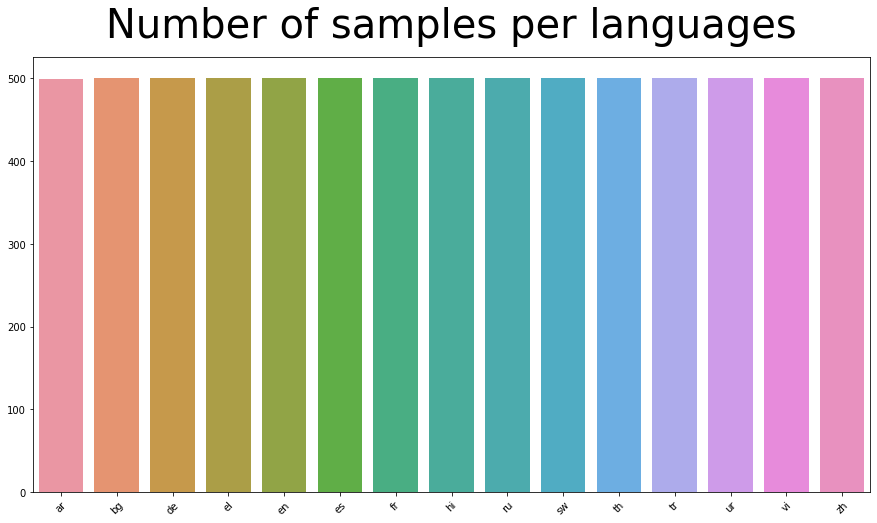

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='languageCode', order = df['languageCode'].value_counts().index.sort_values())
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of samples per languages', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of samples per target')

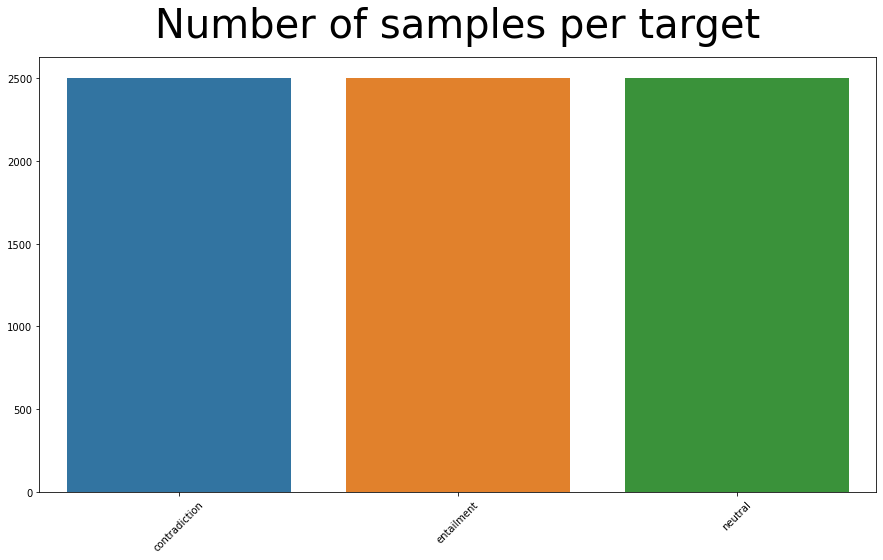

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='target', order = df['target'].value_counts().index.sort_values())
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of samples per target', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of samples per target\n divided by language')

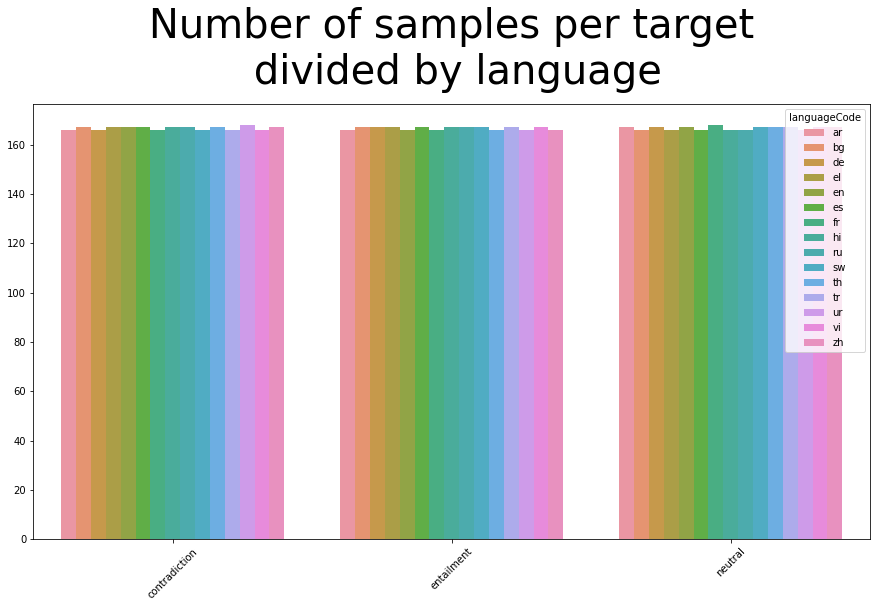

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='target', hue='languageCode', order = df['target'].value_counts().index.sort_values())
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of samples per target\n divided by language', fontsize = 40, pad=20)

Dataset is perfectly balanced, although a bit small. We can divide it into training and testing.

In [ ]:
df_train, df_test = split_dataset(df, train_size_ratio=0.9)
df_minor_language = df[df['languageCode'].isin(['bg','sw','th','tr','vi'])]
print("Length training dataset: ", len(df_train))
print("Length testing dataset: ", len(df_test))
print("Lenght minor languages dataset: ", len(df_minor_language))

Length training dataset:  6736
Length testing dataset:  763
Lenght minor languages dataset:  2500


From this dataset, we will train models from the following languages:
 - Arabic
 - German
 - Greek
 - English
 - Spanish
 - French
 - Hindi
 - Russian
 - Urdu
 - Chinese

We will leave the following as minor languages:
 - Bulgarian
 - Swahili
 - Thailandese
 - Turkish
 - Vietnamese

#### Reddit dataset
We're going to pick 4 different categories of subreddits, divided into 5 different languages, then we will scrape the submissions from each of them.

Chosen categories:
 - politics
 - science
 - sport
 - videogame

Chosen languages:
 - English
 - Italian
 - German
 - Spanish
 - Portuguese

The notebook for the creation of the dataset can be found [here](https://colab.research.google.com/drive/1d9qILauSJ8SW2KvdSdCFCqWTntskY807).

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def upload_from_drive(link, name):
  id = link.split('file/d/')[1].split('/view?usp=sharing')[0]
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(name) 

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1Py8tLtaV5cMPoy6Nw8GO8LBdjNKjXCSg/view?usp=sharing', 'multilingual_reddit.csv')

In [ ]:
df = pd.read_csv('multilingual_reddit.csv')

In [ ]:
len(df)

33854

Text(0.5, 1.0, 'Number of entries per category')

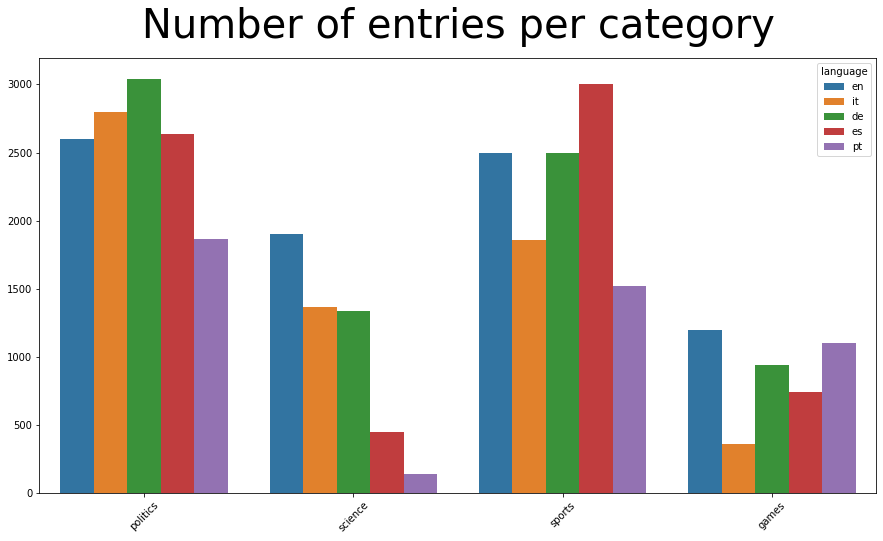

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='category', hue='language')
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of entries per category', fontsize = 40, pad=20)

We will be making the prediction on the submission title

In [ ]:
df['text'] = df['title']
df['target'] = df['category']
df['languageCode'] = df['language']
df = df.drop(df.columns.difference(['text', 'target', 'languageCode']), axis=1)

In [ ]:
df_train, df_test = split_dataset(df)

#### Control data
Built as the Reddit dataset, it's made of the same four categories but in French

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1VWPVy7fNio7hnLWPXzLyRvv4fXxdPLYc/view?usp=sharing', 'multilingual_control.csv')

In [ ]:
df_control = pd.read_csv('multilingual_control.csv')

In [ ]:
df_control.groupby(by='category').count()

,title
category,
Games,5274
Politics,3146
Science,10000
Sports,6667


In [ ]:
df_control = df_control.rename(columns={'title': 'text', 'category': 'target'})
df_control = df_control.sample(n=2000)

### Structure of the experiment
We will be training the models in two ways:
 - Monolingual models will be trained on their own languages
 - Multilingual Bert will be trained on the entire dataset

Testing will be performed on the entire multilingual datasets. We will then compare how each model performed on each language and how they performed on the entire dataset.

In addition to that, we will be testing the models on an extra language (French) on which no training has been performed

Following are three functions to use for training and testing the various models:
 - describe_data -> support function to print info on the dataset
 - model_training -> to train and test the models; saves the results on a .csv and on drive
 - plot_results -> plots the results

In [ ]:
#Support function to give some info on the dataset

def describe_data(df, df_train, df_test):
  length_tot = len(df)
  length_politics = len(df[df['target'] == 'politics'])
  length_science = len(df[df['target'] == 'science'])
  length_sports = len(df[df['target'] == 'sports'])
  length_games = len(df[df['target'] == 'games'])
  perc_politics = length_politics * 100 / length_tot
  perc_science = length_science * 100 / length_tot
  perc_sports = length_sports * 100 / length_tot
  perc_games = length_games * 100 / length_tot
  print(df.info())
  print("\n")
  print("There are {0} politics labels ({1:.2f}%)".format(length_politics, perc_politics))
  print("There are {0} science labels ({1:.2f}%)".format(length_science, perc_science))
  print("There are {0} sports labels ({1:.2f}%)".format(length_sports, perc_sports))
  print("There are {0} games labels ({1:.2f}%)".format(length_games, perc_games))
  print("\n")
  print("Training set: {} rows".format(len(df_train)))
  print("Validation set: {} rows".format(len(df_test)))
  print("Train/Validation ratio: {:.2f}".format(len(df_train)/len(df)))

In [ ]:
"""

Function to train a model and test it on multilingual data. Takes:
 - df_lang    -> dataframe to be used for training and validation (monolingual)
 - df_test    -> testing dataset (multilingual)
 - language   -> language name
 - model_name -> name of the model to train

Returns:
 - df_test + columns 'predictions', 'correct'
 - saves it on .csv file which is sent on drive

"""
def model_training(df_lang, df_test, language, model_name, learning_rate=1e-4):

  #Splits into training and validation
  df_train, df_val = split_dataset(df_lang)

  #Describe the data
  print("{}\n".format(language))
  describe_data(df_lang, df_train, df_val)

  #Prepare the data
  print("Using model: ", model_name)
  t = text.Transformer(model_name, maxlen=128, class_names=['politics', 'science', 'sports', 'games'])
  trn = t.preprocess_train(df_train['text'].tolist(), df_train['target'].tolist())
  val = t.preprocess_test(df_val['text'].tolist(), df_val['target'].tolist())

  #Build learner
  model = t.get_classifier()
  learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=24)

  #Fit model
  learner.fit_onecycle(learning_rate, 4)

  #Validate the model
  print("\nValidation on model trained on {} data".format(language))
  learner.validate()
  
  #Get predictor
  predictor = ktrain.get_predictor(learner.model, preproc=t)
  return predictor

def make_predictions(df_test, predictor):

  #Make predictions on multilingual data
  predictions = return_predictions(df_test, predictor, text_column="text")
  print("\nResults on multilingual data")
  print(confusion_matrix(df_test["target"].tolist(), predictions))
  print(classification_report(df_test["target"].tolist(), predictions))

  #Return
  df_test['predictions'] = predictions
  df_test['correct'] = df_test.apply(lambda row: 'Correct' if str(row['target']) == row['predictions'] else 'Uncorrect', axis=1)

  #Save results
  df_test.to_csv('multilingual_results_' + language + '.csv', index=False)
  save_file_to_drive('multilingual_results_' + language + '.csv', 'multilingual_results_' + language + '.csv')

  return df_test

In [ ]:
#Plots predictions results
def plot_results(df, x, x_label, title, hue='correct'):
  plt.figure(figsize = (15,8))
  plt.xticks(rotation=45, fontsize=10)
  g = sns.countplot(data=df, x=x, hue=hue)
  g.set_xlabel(x_label, fontsize = 20)
  g.set_ylabel('', fontsize = 20)
  g.set_title(title, fontsize = 40, pad=20)
  g.legend(loc = 'upper right')

#### English
Results with training on English data

In [ ]:
df_lang = df_train[df_train['languageCode'] == 'en']
predictor = model_training(df_lang, df_test, language='English', model_name='bert-base-uncased')

English

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6551 entries, 0 to 31353
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          6551 non-null   object
 1   target        6551 non-null   object
 2   languageCode  6551 non-null   object
dtypes: object(3)
memory usage: 204.7+ KB
None


There are 2041 politics labels (31.16%)
There are 1501 science labels (22.91%)
There are 2047 sports labels (31.25%)
There are 962 games labels (14.68%)


Training set: 5229 rows
Validation set: 1322 rows
Train/Validation ratio: 0.80
Using model:  bert-base-uncased



preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 41
	99percentile : 49


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 40
	99percentile : 49





begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
218/218 [==============================] - 57s 260ms/step - loss: 0.4928 - accuracy: 0.8277 - val_loss: 0.2222 - val_accuracy: 0.9259
Epoch 2/4
218/218 [==============================] - 54s 246ms/step - loss: 0.1713 - accuracy: 0.9428 - val_loss: 0.2240 - val_accuracy: 0.9228
Epoch 3/4
218/218 [==============================] - 54s 246ms/step - loss: 0.1237 - accuracy: 0.9640 - val_loss: 0.2000 - val_accuracy: 0.9402
Epoch 4/4
218/218 [==============================] - 54s 246ms/step - loss: 0.0360 - accuracy: 0.9914 - val_loss: 0.2029 - val_accuracy: 0.9463

Validation on model trained on English data
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       198
           1       0.96      0.97      0.97       429
           2       0.94      0.94      0.94       309
           3       0.95      0.96      0.96       386

    accuracy                           0.9

In [ ]:
df_results = make_predictions(df_test, predictor)

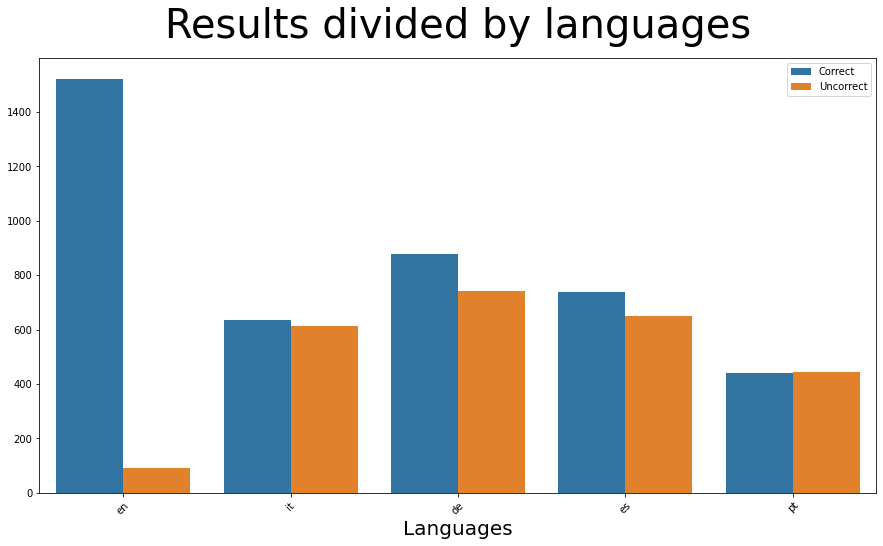

In [ ]:
plot_results(df_results, x='languageCode', x_label='Languages', title='Results divided by languages')

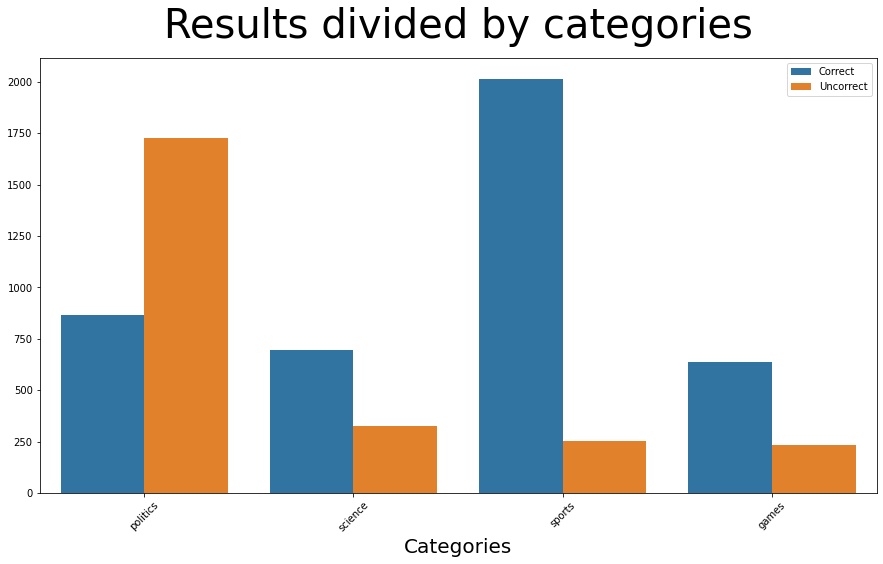

In [ ]:
plot_results(df_results, x='target', x_label='Categories', title='Results divided by categories')

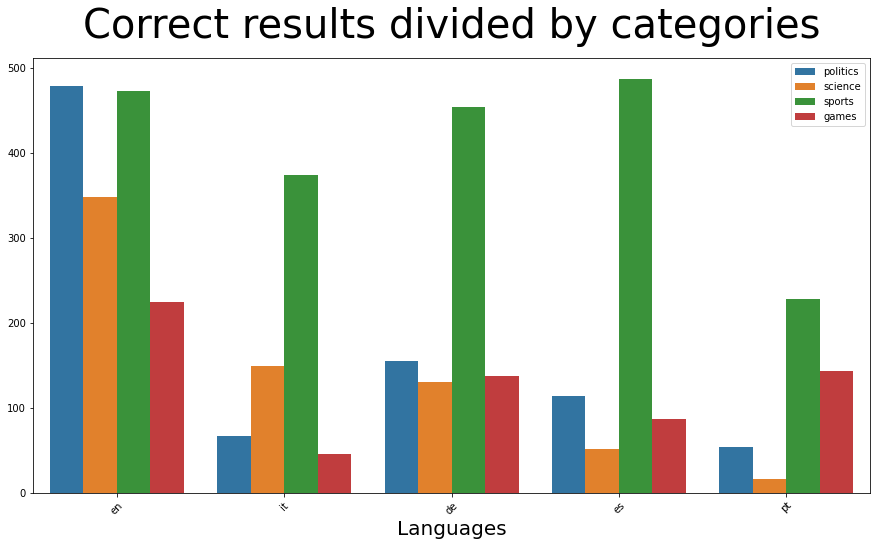

In [ ]:
plot_results(df_results[df_results['correct'] == 'Correct'], x='languageCode', x_label='Languages', title='Correct results divided by categories', hue='target')

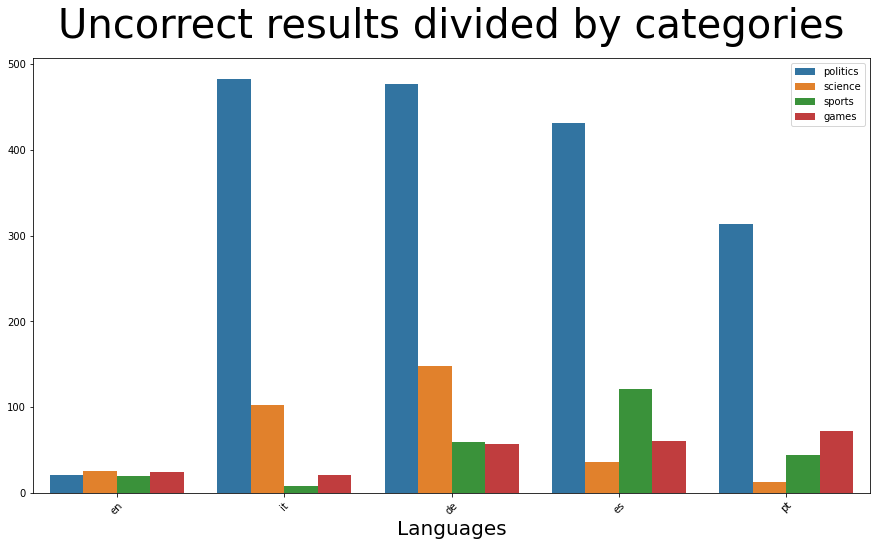

In [ ]:
plot_results(df_results[df_results['correct'] == 'Uncorrect'], x='languageCode', x_label='Languages', title='Uncorrect results divided by categories', hue='target')

In [ ]:
predictions_control = return_predictions(df_control, predictor)

text
Percentage completion: 0.00%
Percentage completion: 1.05%
Percentage completion: 2.10%
Percentage completion: 3.15%
Percentage completion: 4.20%
Percentage completion: 5.25%
Percentage completion: 6.30%
Percentage completion: 7.35%
Percentage completion: 8.40%
Percentage completion: 9.45%
Percentage completion: 10.50%
Percentage completion: 11.55%
Percentage completion: 12.60%
Percentage completion: 13.65%
Percentage completion: 14.70%
Percentage completion: 15.75%
Percentage completion: 16.80%
Percentage completion: 17.85%
Percentage completion: 18.90%
Percentage completion: 19.95%
Percentage completion: 21.00%
Percentage completion: 22.05%
Percentage completion: 23.10%
Percentage completion: 24.15%
Percentage completion: 25.20%
Percentage completion: 26.25%
Percentage completion: 27.30%
Percentage completion: 28.35%
Percentage completion: 29.40%
Percentage completion: 30.45%
Percentage completion: 31.50%
Percentage completion: 32.55%
Percentage completion: 33.60%
Percentage comp

In [ ]:
df_control['predictions'] = predictions_control
df_control['correct'] = df_control.apply(lambda row: 'Correct' if str(row['target']).lower() == row['predictions'] else 'Uncorrect', axis=1)
df_control.groupby(by='correct').count()

,text,target,predictions
correct,,,
Correct,1103,1103,1103
Uncorrect,897,897,897


#### German

In [ ]:
df_lang = df_train[df_train['languageCode'] == 'de']
predictor = model_training(df_lang, df_test, language='German', model_name='bert-base-german-cased')

German

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6267 entries, 7964 to 33853
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          6267 non-null   object
 1   target        6267 non-null   object
 2   languageCode  6267 non-null   object
dtypes: object(3)
memory usage: 195.8+ KB
None


There are 2439 politics labels (38.92%)
There are 1062 science labels (16.95%)
There are 2018 sports labels (32.20%)
There are 748 games labels (11.94%)


Training set: 5057 rows
Validation set: 1210 rows
Train/Validation ratio: 0.81
Using model:  bert-base-german-cased



preprocessing train...
language: de
train sequence lengths:
	mean : 10
	95percentile : 26
	99percentile : 38


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 10
	95percentile : 25
	99percentile : 38





begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
211/211 [==============================] - 55s 259ms/step - loss: 0.5603 - accuracy: 0.7918 - val_loss: 0.3729 - val_accuracy: 0.8603
Epoch 2/4
211/211 [==============================] - 52s 246ms/step - loss: 0.3016 - accuracy: 0.9009 - val_loss: 0.3897 - val_accuracy: 0.8769
Epoch 3/4
211/211 [==============================] - 52s 246ms/step - loss: 0.1749 - accuracy: 0.9429 - val_loss: 0.3975 - val_accuracy: 0.8843
Epoch 4/4
211/211 [==============================] - 52s 245ms/step - loss: 0.0561 - accuracy: 0.9838 - val_loss: 0.4431 - val_accuracy: 0.8901

Validation on model trained on German data
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       146
           1       0.88      0.90      0.89       469
           2       0.79      0.76      0.78       193
           3       0.95      0.96      0.96       402

    accuracy                           0.89

In [ ]:
df_results = make_predictions(df_test, predictor)

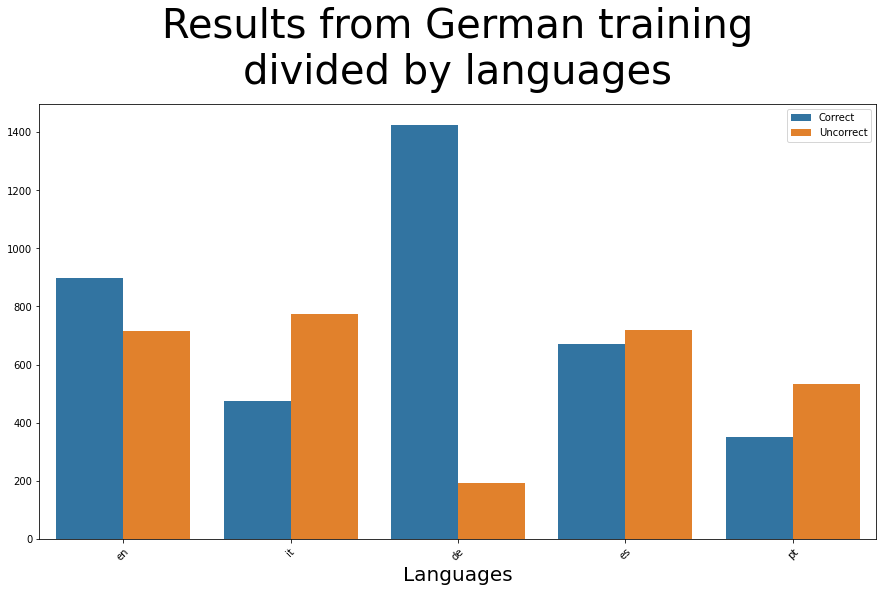

In [ ]:
plot_results(df_results, x='languageCode', x_label='Languages', title='Results from German training\ndivided by languages')

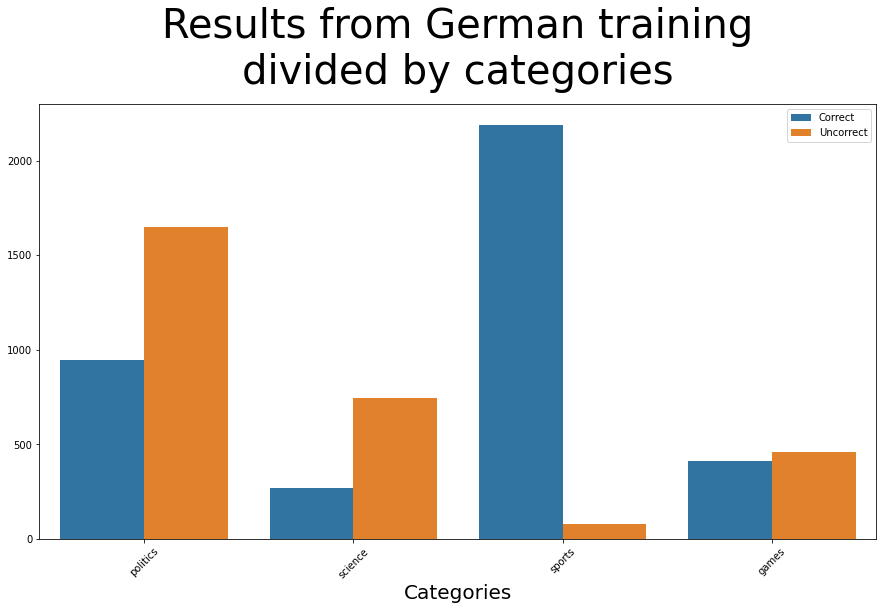

In [ ]:
plot_results(df_results, x='target', x_label='Categories', title='Results from German training\ndivided by categories')

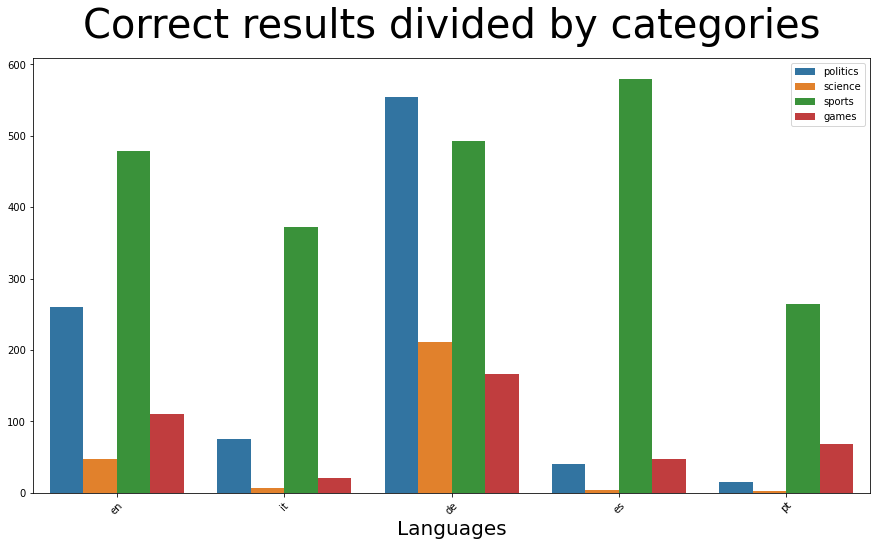

In [ ]:
plot_results(df_results[df_results['correct'] == 'Correct'], x='languageCode', x_label='Languages', title='Correct results divided by categories', hue='target')

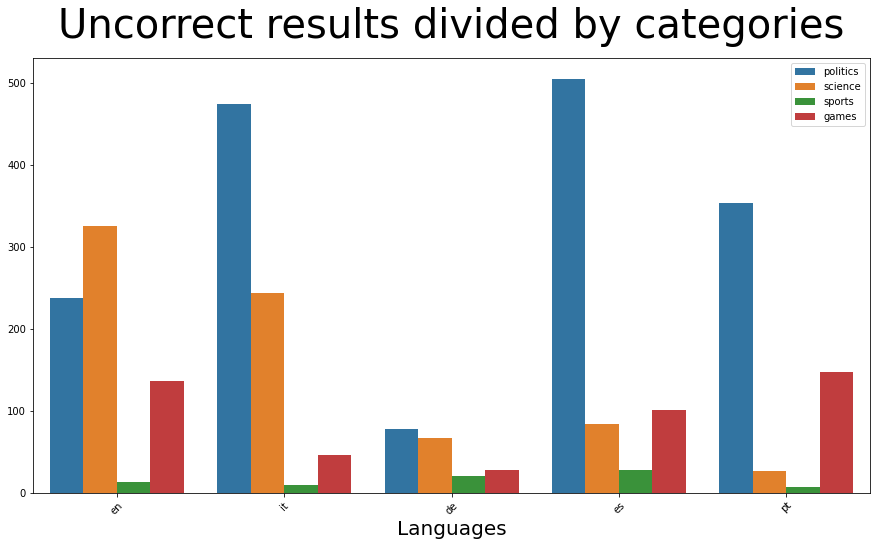

In [ ]:
plot_results(df_results[df_results['correct'] == 'Uncorrect'], x='languageCode', x_label='Languages', title='Uncorrect results divided by categories', hue='target')

In [ ]:
predictions_control = return_predictions(df_control, predictor)

text
Percentage completion: 0.00%
Percentage completion: 1.05%
Percentage completion: 2.10%
Percentage completion: 3.15%
Percentage completion: 4.20%
Percentage completion: 5.25%
Percentage completion: 6.30%
Percentage completion: 7.35%
Percentage completion: 8.40%
Percentage completion: 9.45%
Percentage completion: 10.50%
Percentage completion: 11.55%
Percentage completion: 12.60%
Percentage completion: 13.65%
Percentage completion: 14.70%
Percentage completion: 15.75%
Percentage completion: 16.80%
Percentage completion: 17.85%
Percentage completion: 18.90%
Percentage completion: 19.95%
Percentage completion: 21.00%
Percentage completion: 22.05%
Percentage completion: 23.10%
Percentage completion: 24.15%
Percentage completion: 25.20%
Percentage completion: 26.25%
Percentage completion: 27.30%
Percentage completion: 28.35%
Percentage completion: 29.40%
Percentage completion: 30.45%
Percentage completion: 31.50%
Percentage completion: 32.55%
Percentage completion: 33.60%
Percentage comp

In [ ]:
df_control['predictions'] = predictions_control
df_control['correct'] = df_control.apply(lambda row: 'Correct' if str(row['target']).lower() == row['predictions'] else 'Uncorrect', axis=1)
df_control.groupby(by='correct').count()

,text,target,predictions
correct,,,
Correct,763,763,763
Uncorrect,1237,1237,1237


#### Portuguese

In [ ]:
df_lang = df_train[df_train['languageCode'] == 'pt']
predictor = model_training(df_lang, df_test, language='Portuguese', model_name='neuralmind/bert-base-portuguese-cased')

Portuguese

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3702 entries, 12246 to 21853
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          3702 non-null   object
 1   target        3702 non-null   object
 2   languageCode  3702 non-null   object
dtypes: object(3)
memory usage: 115.7+ KB
None


There are 1504 politics labels (40.63%)
There are 111 science labels (3.00%)
There are 1195 sports labels (32.28%)
There are 892 games labels (24.10%)


Training set: 2909 rows
Validation set: 793 rows
Train/Validation ratio: 0.79
Using model:  neuralmind/bert-base-portuguese-cased



preprocessing train...
language: pt
train sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 42


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: pt
test sequence lengths:
	mean : 10
	95percentile : 19
	99percentile : 40





begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
122/122 [==============================] - 32s 265ms/step - loss: 0.6440 - accuracy: 0.7762 - val_loss: 0.3511 - val_accuracy: 0.8815
Epoch 2/4
122/122 [==============================] - 30s 245ms/step - loss: 0.2888 - accuracy: 0.9075 - val_loss: 0.3421 - val_accuracy: 0.8865
Epoch 3/4
122/122 [==============================] - 30s 245ms/step - loss: 0.1859 - accuracy: 0.9443 - val_loss: 0.3418 - val_accuracy: 0.8991
Epoch 4/4
122/122 [==============================] - 30s 245ms/step - loss: 0.0648 - accuracy: 0.9821 - val_loss: 0.3474 - val_accuracy: 0.8953

Validation on model trained on Portuguese data
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       182
           1       0.91      0.92      0.92       331
           2       0.50      0.37      0.42        19
           3       0.89      0.90      0.89       261

    accuracy                           

In [ ]:
df_results = make_predictions(df_test, predictor)

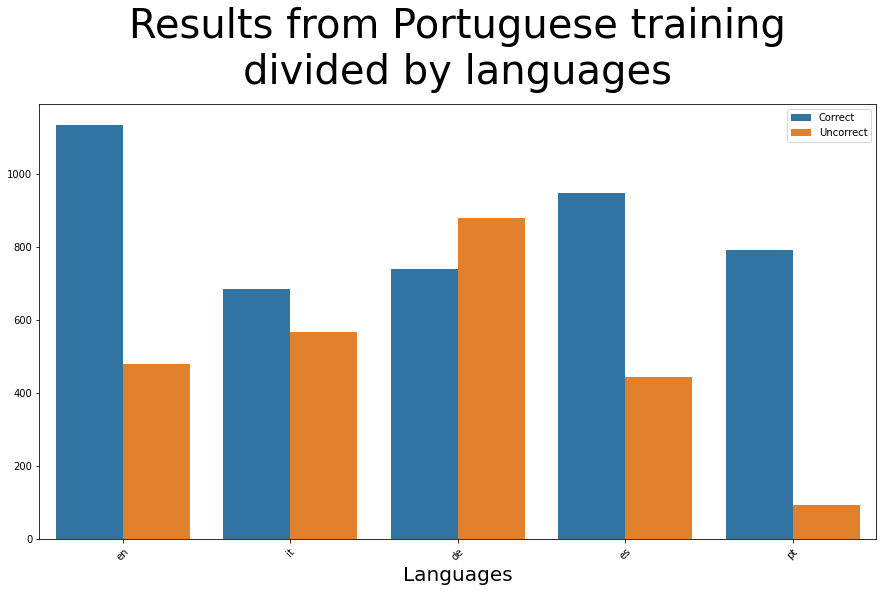

In [ ]:
plot_results(df_results, x='languageCode', x_label='Languages', title='Results from Portuguese training\ndivided by languages')

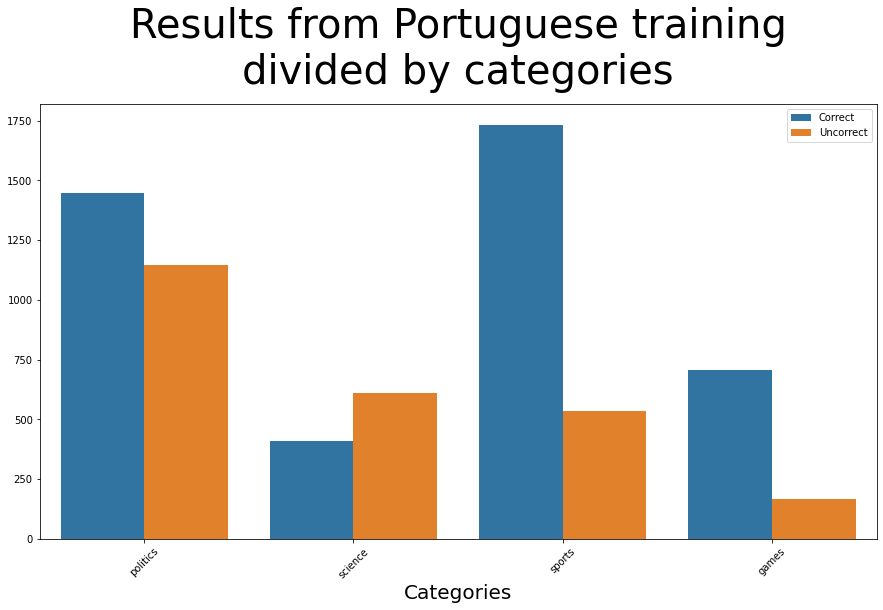

In [ ]:
plot_results(df_results, x='target', x_label='Categories', title='Results from Portuguese training\ndivided by categories')

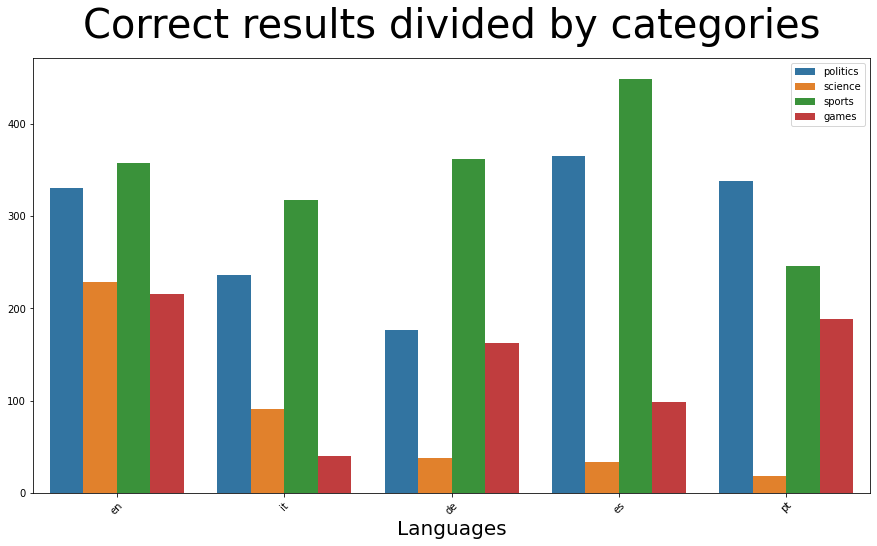

In [ ]:
plot_results(df_results[df_results['correct'] == 'Correct'], x='languageCode', x_label='Languages', title='Correct results divided by categories', hue='target')

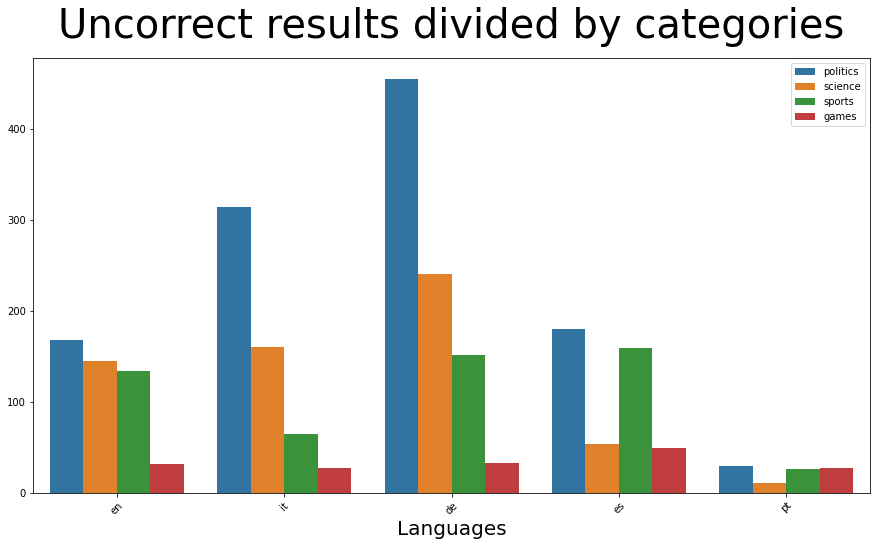

In [ ]:
plot_results(df_results[df_results['correct'] == 'Uncorrect'], x='languageCode', x_label='Languages', title='Uncorrect results divided by categories', hue='target')

In [ ]:
predictions_control = return_predictions(df_control, predictor)

text
Percentage completion: 0.00%
Percentage completion: 1.05%
Percentage completion: 2.10%
Percentage completion: 3.15%
Percentage completion: 4.20%
Percentage completion: 5.25%
Percentage completion: 6.30%
Percentage completion: 7.35%
Percentage completion: 8.40%
Percentage completion: 9.45%
Percentage completion: 10.50%
Percentage completion: 11.55%
Percentage completion: 12.60%
Percentage completion: 13.65%
Percentage completion: 14.70%
Percentage completion: 15.75%
Percentage completion: 16.80%
Percentage completion: 17.85%
Percentage completion: 18.90%
Percentage completion: 19.95%
Percentage completion: 21.00%
Percentage completion: 22.05%
Percentage completion: 23.10%
Percentage completion: 24.15%
Percentage completion: 25.20%
Percentage completion: 26.25%
Percentage completion: 27.30%
Percentage completion: 28.35%
Percentage completion: 29.40%
Percentage completion: 30.45%
Percentage completion: 31.50%
Percentage completion: 32.55%
Percentage completion: 33.60%
Percentage comp

In [ ]:
df_control['predictions'] = predictions_control
df_control['correct'] = df_control.apply(lambda row: 'Correct' if str(row['target']).lower() == row['predictions'] else 'Uncorrect', axis=1)
df_control.groupby(by='correct').count()

,text,target,predictions
correct,,,
Correct,798,798,798
Uncorrect,1202,1202,1202


#### Spanish

In [ ]:
df_lang = df_train[df_train['languageCode'] == 'es']
predictor = model_training(df_lang, df_test, language='Spanish', model_name='dccuchile/bert-base-spanish-wwm-uncased')

Spanish

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5437 entries, 8464 to 28853
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5437 non-null   object
 1   target        5437 non-null   object
 2   languageCode  5437 non-null   object
dtypes: object(3)
memory usage: 169.9+ KB
None


There are 2085 politics labels (38.35%)
There are 359 science labels (6.60%)
There are 2395 sports labels (44.05%)
There are 598 games labels (11.00%)


Training set: 4388 rows
Validation set: 1049 rows
Train/Validation ratio: 0.81
Using model:  dccuchile/bert-base-spanish-wwm-uncased



preprocessing train...
language: es
train sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 37


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: es
test sequence lengths:
	mean : 11
	95percentile : 21
	99percentile : 38





begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
183/183 [==============================] - 47s 258ms/step - loss: 0.4609 - accuracy: 0.8350 - val_loss: 0.1866 - val_accuracy: 0.9399
Epoch 2/4
183/183 [==============================] - 45s 244ms/step - loss: 0.2173 - accuracy: 0.9328 - val_loss: 0.2007 - val_accuracy: 0.9390
Epoch 3/4
183/183 [==============================] - 45s 244ms/step - loss: 0.1354 - accuracy: 0.9613 - val_loss: 0.1946 - val_accuracy: 0.9418
Epoch 4/4
183/183 [==============================] - 45s 245ms/step - loss: 0.0516 - accuracy: 0.9877 - val_loss: 0.2065 - val_accuracy: 0.9380

Validation on model trained on Spanish data
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       102
           1       0.97      0.95      0.96       400
           2       0.84      0.75      0.79        72
           3       0.96      0.96      0.96       475

    accuracy                           0.9

In [ ]:
df_results = make_predictions(df_test, predictor)

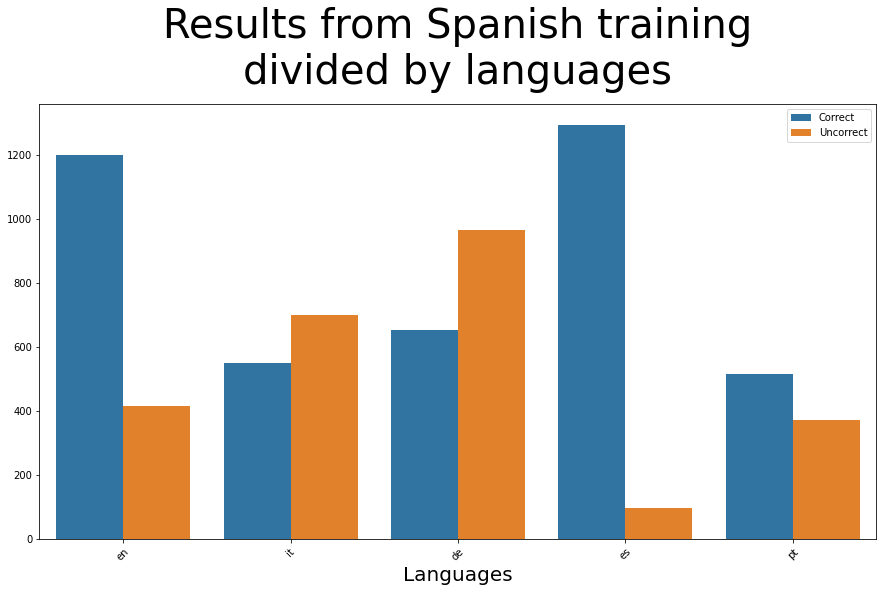

In [ ]:
plot_results(df_results, x='languageCode', x_label='Languages', title='Results from Spanish training\ndivided by languages')

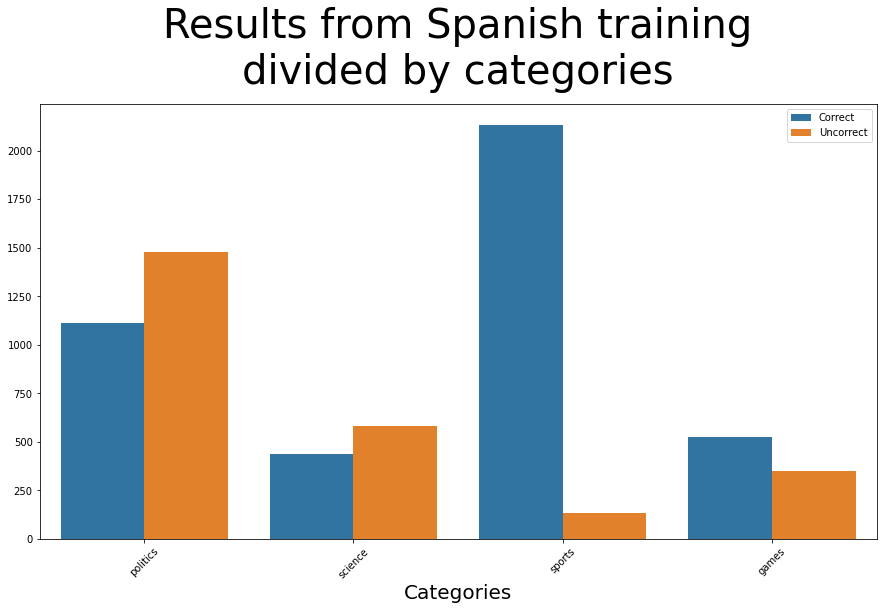

In [ ]:
plot_results(df_results, x='target', x_label='Categories', title='Results from Spanish training\ndivided by categories')

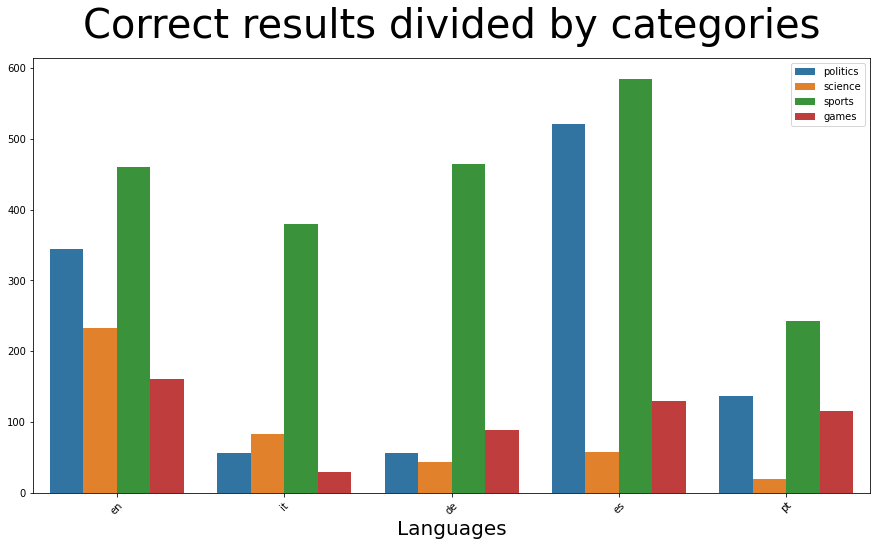

In [ ]:
plot_results(df_results[df_results['correct'] == 'Correct'], x='languageCode', x_label='Languages', title='Correct results divided by categories', hue='target')

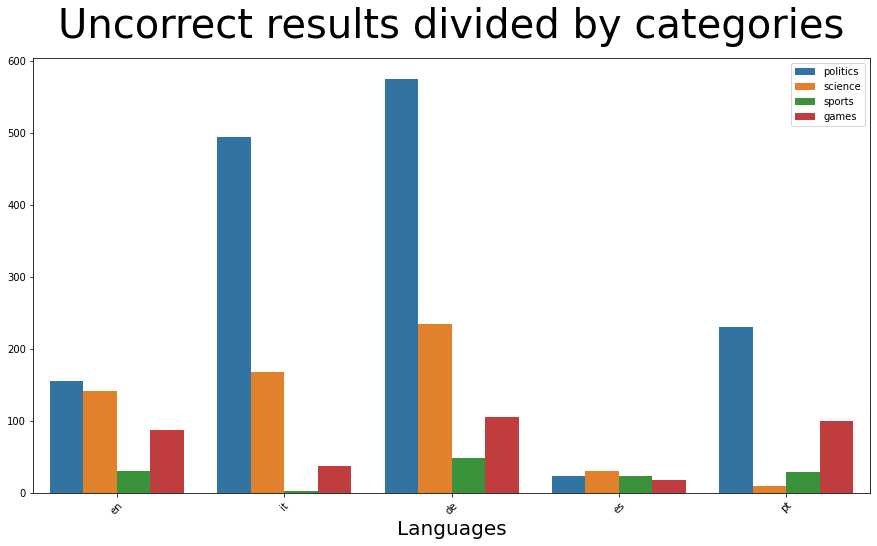

In [ ]:
plot_results(df_results[df_results['correct'] == 'Uncorrect'], x='languageCode', x_label='Languages', title='Uncorrect results divided by categories', hue='target')

In [ ]:
predictions_control = return_predictions(df_control, predictor)

text
Percentage completion: 0.00%
Percentage completion: 1.05%
Percentage completion: 2.10%
Percentage completion: 3.15%
Percentage completion: 4.20%
Percentage completion: 5.25%
Percentage completion: 6.30%
Percentage completion: 7.35%
Percentage completion: 8.40%
Percentage completion: 9.45%
Percentage completion: 10.50%
Percentage completion: 11.55%
Percentage completion: 12.60%
Percentage completion: 13.65%
Percentage completion: 14.70%
Percentage completion: 15.75%
Percentage completion: 16.80%
Percentage completion: 17.85%
Percentage completion: 18.90%
Percentage completion: 19.95%
Percentage completion: 21.00%
Percentage completion: 22.05%
Percentage completion: 23.10%
Percentage completion: 24.15%
Percentage completion: 25.20%
Percentage completion: 26.25%
Percentage completion: 27.30%
Percentage completion: 28.35%
Percentage completion: 29.40%
Percentage completion: 30.45%
Percentage completion: 31.50%
Percentage completion: 32.55%
Percentage completion: 33.60%
Percentage comp

In [ ]:
df_control['predictions'] = predictions_control
df_control['correct'] = df_control.apply(lambda row: 'Correct' if str(row['target']).lower() == row['predictions'] else 'Uncorrect', axis=1)
df_control.groupby(by='correct').count()

,text,target,predictions
correct,,,
Correct,877,877,877
Uncorrect,1123,1123,1123


#### Italian

In [ ]:
df_lang = df_train[df_train['languageCode'] == 'it']
predictor = model_training(df_lang, df_test, language='Italian', model_name='dbmdz/bert-base-italian-uncased')

Italian

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5121 entries, 4500 to 24653
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5121 non-null   object
 1   target        5121 non-null   object
 2   languageCode  5121 non-null   object
dtypes: object(3)
memory usage: 160.0+ KB
None


There are 2256 politics labels (44.05%)
There are 1078 science labels (21.05%)
There are 1494 sports labels (29.17%)
There are 293 games labels (5.72%)


Training set: 4163 rows
Validation set: 958 rows
Train/Validation ratio: 0.81
Using model:  dbmdz/bert-base-italian-uncased



preprocessing train...
language: it
train sequence lengths:
	mean : 9
	95percentile : 17
	99percentile : 23


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: it
test sequence lengths:
	mean : 9
	95percentile : 18
	99percentile : 24





begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
174/174 [==============================] - 45s 260ms/step - loss: 0.5679 - accuracy: 0.7865 - val_loss: 0.3052 - val_accuracy: 0.9081
Epoch 2/4
174/174 [==============================] - 42s 244ms/step - loss: 0.2627 - accuracy: 0.9145 - val_loss: 0.2522 - val_accuracy: 0.9228
Epoch 3/4
174/174 [==============================] - 42s 244ms/step - loss: 0.1364 - accuracy: 0.9596 - val_loss: 0.2457 - val_accuracy: 0.9301
Epoch 4/4
174/174 [==============================] - 42s 243ms/step - loss: 0.0498 - accuracy: 0.9849 - val_loss: 0.2343 - val_accuracy: 0.9395

Validation on model trained on Italian data
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        50
           1       0.95      0.94      0.94       442
           2       0.86      0.90      0.88       177
           3       0.99      0.97      0.98       289

    accuracy                           0.9

In [ ]:
df_results = make_predictions(df_test, predictor)

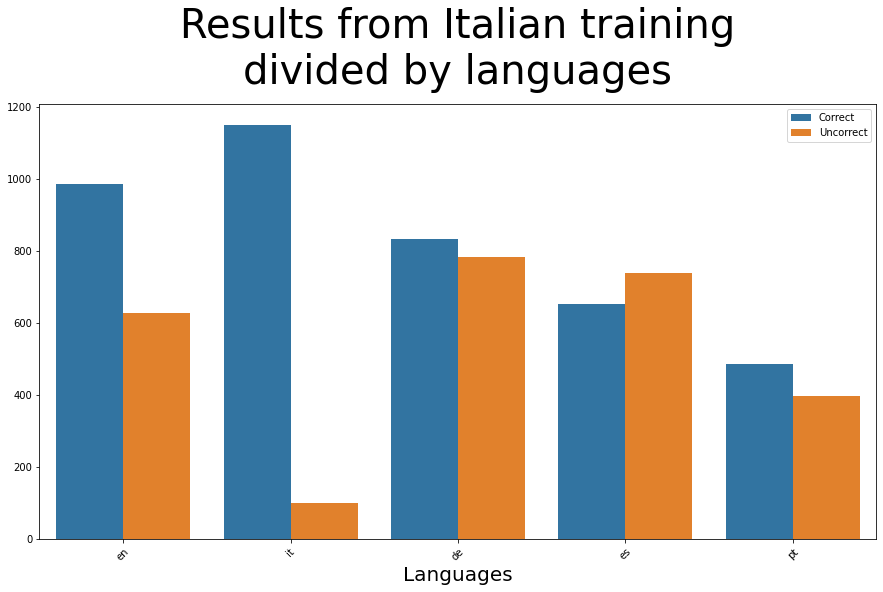

In [ ]:
plot_results(df_results, x='languageCode', x_label='Languages', title='Results from Italian training\ndivided by languages')

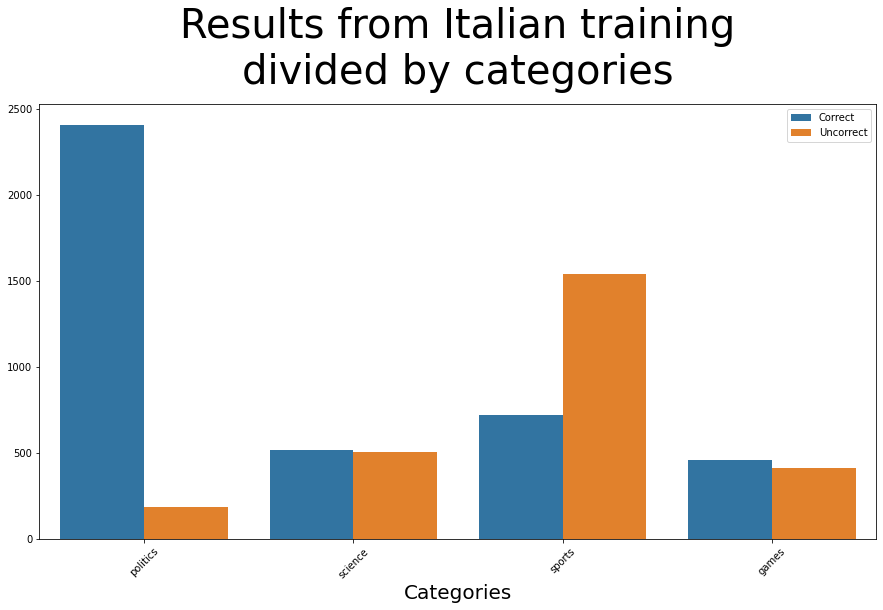

In [ ]:
plot_results(df_results, x='target', x_label='Categories', title='Results from Italian training\ndivided by categories')

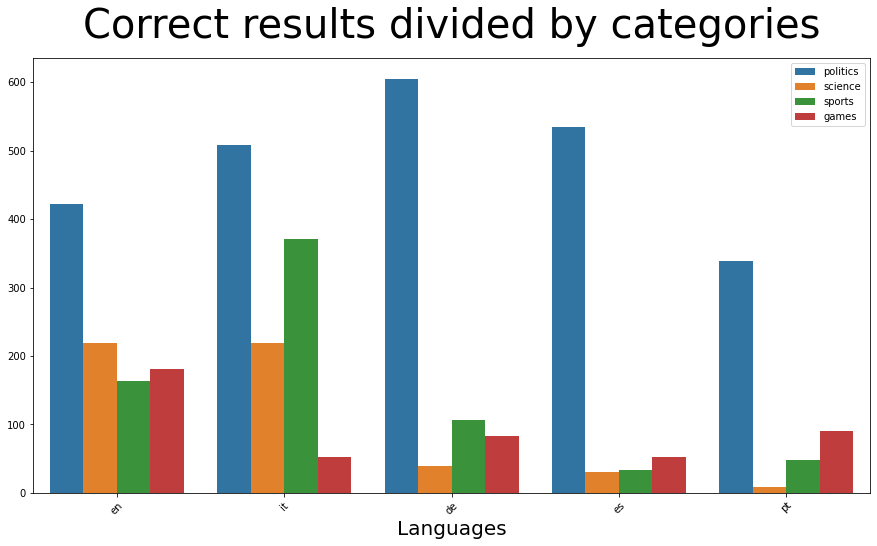

In [ ]:
plot_results(df_results[df_results['correct'] == 'Correct'], x='languageCode', x_label='Languages', title='Correct results divided by categories', hue='target')

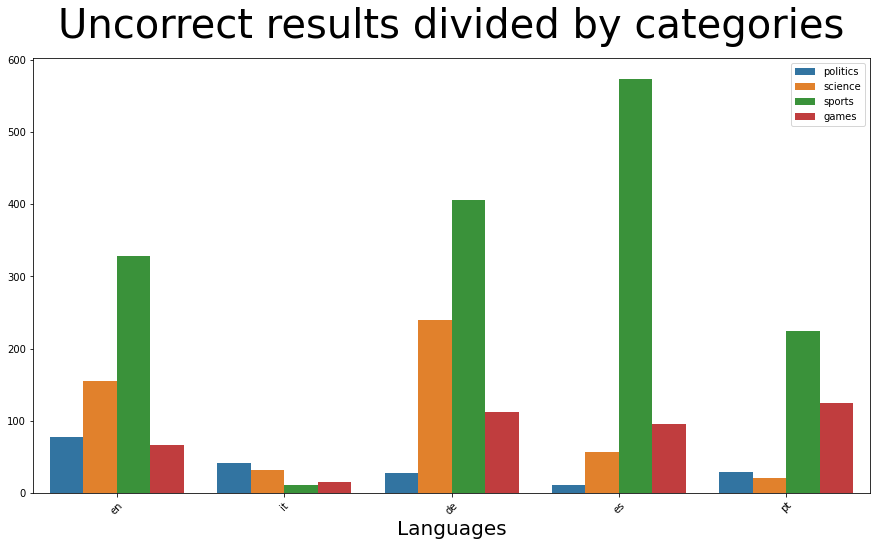

In [ ]:
plot_results(df_results[df_results['correct'] == 'Uncorrect'], x='languageCode', x_label='Languages', title='Uncorrect results divided by categories', hue='target')

In [ ]:
predictions_control = return_predictions(df_control, predictor)

text
Percentage completion: 0.00%
Percentage completion: 1.05%
Percentage completion: 2.10%
Percentage completion: 3.15%
Percentage completion: 4.20%
Percentage completion: 5.25%
Percentage completion: 6.30%
Percentage completion: 7.35%
Percentage completion: 8.40%
Percentage completion: 9.45%
Percentage completion: 10.50%
Percentage completion: 11.55%
Percentage completion: 12.60%
Percentage completion: 13.65%
Percentage completion: 14.70%
Percentage completion: 15.75%
Percentage completion: 16.80%
Percentage completion: 17.85%
Percentage completion: 18.90%
Percentage completion: 19.95%
Percentage completion: 21.00%
Percentage completion: 22.05%
Percentage completion: 23.10%
Percentage completion: 24.15%
Percentage completion: 25.20%
Percentage completion: 26.25%
Percentage completion: 27.30%
Percentage completion: 28.35%
Percentage completion: 29.40%
Percentage completion: 30.45%
Percentage completion: 31.50%
Percentage completion: 32.55%
Percentage completion: 33.60%
Percentage comp

In [ ]:
df_control['predictions'] = predictions_control
df_control['correct'] = df_control.apply(lambda row: 'Correct' if str(row['target']).lower() == row['predictions'] else 'Uncorrect', axis=1)
df_control.groupby(by='correct').count()

,text,target,predictions
correct,,,
Correct,786,786,786
Uncorrect,1214,1214,1214


#### Multilingual

In [ ]:
df_lang = df_train
predictor = model_training(df_lang, df_test, language='Multilingual', model_name='bert-base-multilingual-cased')

Multilingual

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27078 entries, 0 to 33853
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          27078 non-null  object
 1   target        27078 non-null  object
 2   languageCode  27078 non-null  object
dtypes: object(3)
memory usage: 846.2+ KB
None


There are 10325 politics labels (38.13%)
There are 4111 science labels (15.18%)
There are 9149 sports labels (33.79%)
There are 3493 games labels (12.90%)


Training set: 21594 rows
Validation set: 5484 rows
Train/Validation ratio: 0.80
Using model:  bert-base-multilingual-cased



preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 27
	99percentile : 44


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 26
	99percentile : 45





begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
900/900 [==============================] - 231s 257ms/step - loss: 0.4672 - accuracy: 0.8333 - val_loss: 0.3639 - val_accuracy: 0.8704
Epoch 2/4
900/900 [==============================] - 228s 254ms/step - loss: 0.3469 - accuracy: 0.8795 - val_loss: 0.4465 - val_accuracy: 0.8496
Epoch 3/4
900/900 [==============================] - 229s 254ms/step - loss: 0.2404 - accuracy: 0.9192 - val_loss: 0.3974 - val_accuracy: 0.8827
Epoch 4/4
900/900 [==============================] - 229s 254ms/step - loss: 0.0934 - accuracy: 0.9711 - val_loss: 0.3894 - val_accuracy: 0.8931

Validation on model trained on Multilingual data
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       731
           1       0.89      0.92      0.90      2056
           2       0.83      0.80      0.82       829
           3       0.94      0.92      0.93      1868

    accuracy                     

In [ ]:
df_results = make_predictions(df_test, predictor)

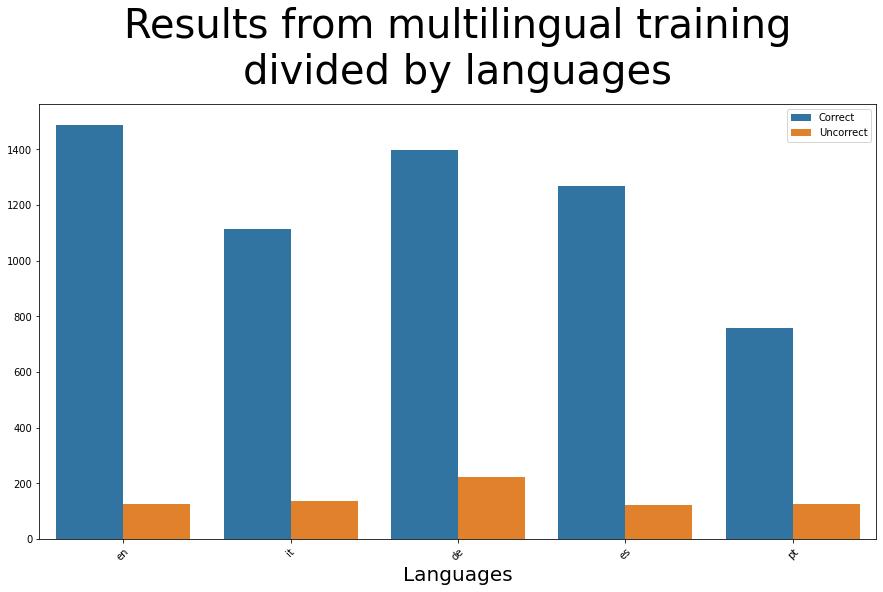

In [ ]:
plot_results(df_results, x='languageCode', x_label='Languages', title='Results from multilingual training\ndivided by languages')

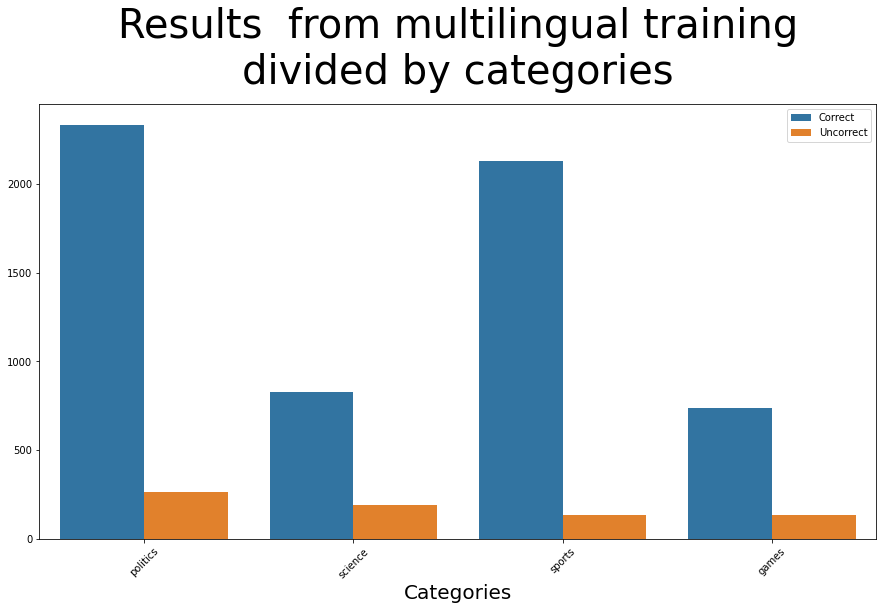

In [ ]:
plot_results(df_results, x='target', x_label='Categories', title='Results  from multilingual training\ndivided by categories')

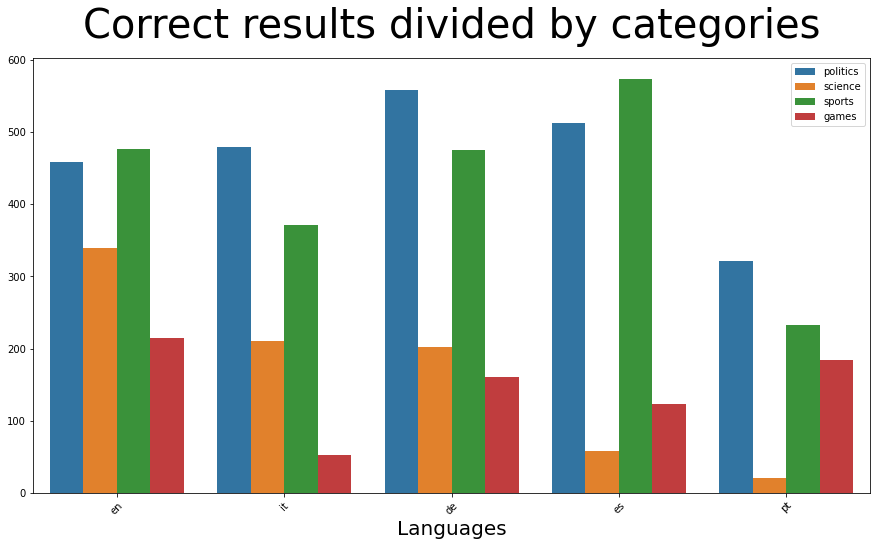

In [ ]:
plot_results(df_results[df_results['correct'] == 'Correct'], x='languageCode', x_label='Languages', title='Correct results divided by categories', hue='target')

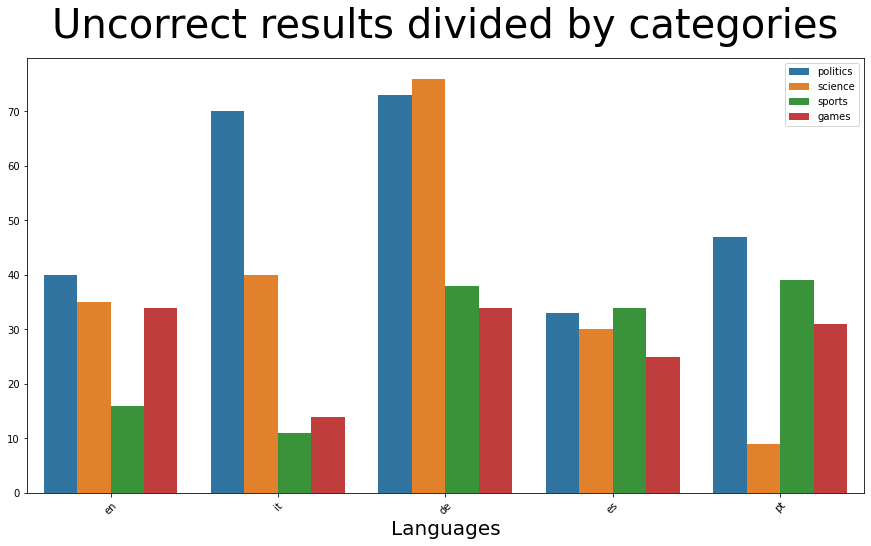

In [ ]:
plot_results(df_results[df_results['correct'] == 'Uncorrect'], x='languageCode', x_label='Languages', title='Uncorrect results divided by categories', hue='target')

In [ ]:
predictions_control = return_predictions(df_control, predictor)

text
Percentage completion: 0.00%
Percentage completion: 1.05%
Percentage completion: 2.10%
Percentage completion: 3.15%
Percentage completion: 4.20%
Percentage completion: 5.25%
Percentage completion: 6.30%
Percentage completion: 7.35%
Percentage completion: 8.40%
Percentage completion: 9.45%
Percentage completion: 10.50%
Percentage completion: 11.55%
Percentage completion: 12.60%
Percentage completion: 13.65%
Percentage completion: 14.70%
Percentage completion: 15.75%
Percentage completion: 16.80%
Percentage completion: 17.85%
Percentage completion: 18.90%
Percentage completion: 19.95%
Percentage completion: 21.00%
Percentage completion: 22.05%
Percentage completion: 23.10%
Percentage completion: 24.15%
Percentage completion: 25.20%
Percentage completion: 26.25%
Percentage completion: 27.30%
Percentage completion: 28.35%
Percentage completion: 29.40%
Percentage completion: 30.45%
Percentage completion: 31.50%
Percentage completion: 32.55%
Percentage completion: 33.60%
Percentage comp

In [ ]:
df_control['predictions'] = predictions_control
df_control['correct'] = df_control.apply(lambda row: 'Correct' if str(row['target']).lower() == row['predictions'] else 'Uncorrect', axis=1)
df_control.groupby(by='correct').count()

,text,target,predictions
correct,,,
Correct,1238,1238,1238
Uncorrect,762,762,762


### Analysis on the results
In the following cells, we will be giving an overview of the results for each of the models.

In [ ]:
df_en = pd.read_csv('multilingual_results_English.csv')
df_de = pd.read_csv('multilingual_results_German.csv')
df_it = pd.read_csv('multilingual_results_Italian.csv')
df_es = pd.read_csv('multilingual_results_Spanish.csv')
df_pt = pd.read_csv('multilingual_results_Portuguese.csv')
df_mu = pd.read_csv('multilingual_results_Multilingual.csv')

In [ ]:
pd.set_option('display.max_rows', 100)

#### English

The inital dataset used for fine-tuning was divided as following:
 - 2101 politics labels (31.90%)
 - 1526 science labels (23.17%)
 - 2008 sports labels (30.48%)
 - 952 games labels (14.45%)

In [ ]:
df_en['total'] = 1

LABEL DISTRIBUTION

In [ ]:
df_grouped = df_en.groupby(by=['languageCode', 'target']).count()
df_grouped['lang'] = [index[0] for index in df_grouped.index]
df_grouped['perc'] = df_grouped.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_en[df_en['languageCode'] == row['lang']])), axis=1)
df_grouped[['total', 'perc']]

total   perc
languageCode target                
de           games       195  12.05
             politics    632  39.06
             science     278  17.18
             sports      513  31.71
en           games       248  15.38
             politics    499  30.94
             science     374  23.19
             sports      492  30.50
es           games       148  10.66
             politics    545  39.24
             science      88   6.34
             sports      608  43.77
it           games        67   5.36
             politics    550  44.00
             science     251  20.08
             sports      382  30.56
pt           games       215  24.32
             politics    368  41.63
             science      29   3.28
             sports      272  30.77

PREDICTION DISTRIBUTION

In [ ]:
df_grouped_prediction = df_en.groupby(by=['languageCode', 'predictions']).count()
df_grouped_prediction['lang'] = [index[0] for index in df_grouped_prediction.index]
df_grouped_prediction['perc'] = df_grouped_prediction.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_en[df_en['languageCode'] == row['lang']])), axis=1)
df_grouped_prediction[['total', 'perc']]

total   perc
languageCode predictions              
de           games          385  23.79
             politics       188  11.62
             science        267  16.50
             sports         778  48.08
en           games          252  15.62
             politics       504  31.25
             science        368  22.81
             sports         489  30.32
es           games          189  13.61
             politics       153  11.02
             science        253  18.21
             sports         794  57.16
it           games          126  10.08
             politics        74   5.92
             science        239  19.12
             sports         811  64.88
pt           games          235  26.58
             politics        65   7.35
             science         98  11.09
             sports         486  54.98

CORRECT PREDICTION DISTRIBUTION + PRECISION

In [ ]:
df_grouped_correct = df_en.groupby(by=['languageCode', 'predictions']).sum()
df_grouped_correct['precision'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'precision']]

correct  total precision
languageCode predictions                          
de           games            138    385      0.36
             politics         155    188      0.82
             science          130    267      0.49
             sports           454    778      0.58
en           games            224    252      0.89
             politics         478    504      0.95
             science          348    368      0.95
             sports           472    489      0.97
es           games             87    189      0.46
             politics         114    153      0.75
             science           52    253      0.21
             sports           487    794      0.61
it           games             46    126      0.37
             politics          67     74      0.91
             science          149    239      0.62
             sports           374    811      0.46
pt           games            143    235      0.61
             politics          54     65      0.83
             science           16     98      0.16
             sports           228    486      0.47

RECALL

In [ ]:
df_grouped_correct = df_en.groupby(by=['languageCode', 'target']).sum()
df_grouped_correct['recall'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'total', 'recall']]

correct  total recall
languageCode target                         
de           games         138    195   0.71
             politics      155    632   0.25
             science       130    278   0.47
             sports        454    513   0.88
en           games         224    248   0.90
             politics      478    499   0.96
             science       348    374   0.93
             sports        472    492   0.96
es           games          87    148   0.59
             politics      114    545   0.21
             science        52     88   0.59
             sports        487    608   0.80
it           games          46     67   0.69
             politics       67    550   0.12
             science       149    251   0.59
             sports        374    382   0.98
pt           games         143    215   0.67
             politics       54    368   0.15
             science        16     29   0.55
             sports        228    272   0.84

ACCURACY

In [ ]:
df_grouped = df_en.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
languageCode,,,
de,877,1618,0.54
en,1522,1613,0.94
es,740,1389,0.53
it,636,1250,0.51
pt,441,884,0.50


In [ ]:
df_grouped = df_en.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
target,,,
games,638,873,0.73
politics,868,2594,0.33
science,695,1020,0.68
sports,2015,2267,0.89


#### German

The inital dataset used for fine-tuning was divided as following:
 - 2409 politics labels (38.85%)
 - 1058 science labels (17.06%)
 - 1987 sports labels (32.04%)
 - 747 games labels (12.05%)

In [ ]:
df_de['total'] = 1
df_de['correct'] = df_de['correct'].apply(lambda row: 1 if row == 'Correct' else 0)

LABEL DISTRIBUTION

In [ ]:
df_grouped = df_de.groupby(by=['languageCode', 'target']).count()
df_grouped['lang'] = [index[0] for index in df_grouped.index]
df_grouped['perc'] = df_grouped.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_de[df_de['languageCode'] == row['lang']])), axis=1)
df_grouped[['total', 'perc']]

total   perc
languageCode target                
de           games       195  12.05
             politics    632  39.06
             science     278  17.18
             sports      513  31.71
en           games       248  15.38
             politics    499  30.94
             science     374  23.19
             sports      492  30.50
es           games       148  10.66
             politics    545  39.24
             science      88   6.34
             sports      608  43.77
it           games        67   5.36
             politics    550  44.00
             science     251  20.08
             sports      382  30.56
pt           games       215  24.32
             politics    368  41.63
             science      29   3.28
             sports      272  30.77

PREDICTION DISTRIBUTION

In [ ]:
df_grouped_prediction = df_de.groupby(by=['languageCode', 'predictions']).count()
df_grouped_prediction['lang'] = [index[0] for index in df_grouped_prediction.index]
df_grouped_prediction['perc'] = df_grouped_prediction.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_de[df_de['languageCode'] == row['lang']])), axis=1)
df_grouped_prediction[['total', 'perc']]

total   perc
languageCode predictions              
de           games          206  12.73
             politics       617  38.13
             science        268  16.56
             sports         527  32.57
en           games          143   8.87
             politics       287  17.79
             science         57   3.53
             sports        1126  69.81
es           games           80   5.76
             politics        50   3.60
             science         11   0.79
             sports        1248  89.85
it           games           43   3.44
             politics        85   6.80
             science          9   0.72
             sports        1113  89.04
pt           games           84   9.50
             politics        15   1.70
             science          6   0.68
             sports         779  88.12

CORRECT PREDICTION DISTRIBUTION + PRECISION

In [ ]:
df_grouped_correct = df_de.groupby(by=['languageCode', 'predictions']).sum()
df_grouped_correct['precision'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'precision']]

correct precision
languageCode predictions                   
de           games            167      0.81
             politics         554      0.90
             science          211      0.79
             sports           493      0.94
en           games            111      0.78
             politics         261      0.91
             science           48      0.84
             sports           479      0.43
es           games             47      0.59
             politics          40      0.80
             science            4      0.36
             sports           580      0.46
it           games             21      0.49
             politics          76      0.89
             science            7      0.78
             sports           372      0.33
pt           games             68      0.81
             politics          15      1.00
             science            2      0.33
             sports           265      0.34

RECALL

In [ ]:
df_grouped_correct = df_de.groupby(by=['languageCode', 'target']).sum()
df_grouped_correct['recall'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'total', 'recall']]

correct  total recall
languageCode target                         
de           games         167    195   0.86
             politics      554    632   0.88
             science       211    278   0.76
             sports        493    513   0.96
en           games         111    248   0.45
             politics      261    499   0.52
             science        48    374   0.13
             sports        479    492   0.97
es           games          47    148   0.32
             politics       40    545   0.07
             science         4     88   0.05
             sports        580    608   0.95
it           games          21     67   0.31
             politics       76    550   0.14
             science         7    251   0.03
             sports        372    382   0.97
pt           games          68    215   0.32
             politics       15    368   0.04
             science         2     29   0.07
             sports        265    272   0.97

ACCURACY

In [ ]:
df_grouped = df_de.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
languageCode,,,
de,1425,1618,0.88
en,899,1613,0.56
es,671,1389,0.48
it,476,1250,0.38
pt,350,884,0.40


In [ ]:
df_grouped = df_de.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
target,,,
games,414,873,0.47
politics,946,2594,0.36
science,272,1020,0.27
sports,2189,2267,0.97


#### Portuguese

The inital dataset used for fine-tuning was divided as following:
 - 1496 politics labels (39.97%)
 - 112 science labels (2.99%)
 - 1250 sports labels (33.40%)
 - 885 games labels (23.64%)

In [ ]:
df_pt['total'] = 1
df_pt['correct'] = df_pt['correct'].apply(lambda row: 1 if row == 'Correct' else 0)

LABEL DISTRIBUTION

In [ ]:
df_grouped = df_pt.groupby(by=['languageCode', 'target']).count()
df_grouped['lang'] = [index[0] for index in df_grouped.index]
df_grouped['perc'] = df_grouped.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_pt[df_pt['languageCode'] == row['lang']])), axis=1)
df_grouped[['total', 'perc']]

total   perc
languageCode target                
de           games       195  12.05
             politics    632  39.06
             science     278  17.18
             sports      513  31.71
en           games       248  15.38
             politics    499  30.94
             science     374  23.19
             sports      492  30.50
es           games       148  10.66
             politics    545  39.24
             science      88   6.34
             sports      608  43.77
it           games        67   5.36
             politics    550  44.00
             science     251  20.08
             sports      382  30.56
pt           games       215  24.32
             politics    368  41.63
             science      29   3.28
             sports      272  30.77

PREDICTION DISTRIBUTION

In [ ]:
df_grouped_prediction = df_pt.groupby(by=['languageCode', 'predictions']).count()
df_grouped_prediction['lang'] = [index[0] for index in df_grouped_prediction.index]
df_grouped_prediction['perc'] = df_grouped_prediction.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_pt[df_pt['languageCode'] == row['lang']])), axis=1)
df_grouped_prediction[['total', 'perc']]

total   perc
languageCode predictions              
de           games          718  44.38
             politics       247  15.27
             science         81   5.01
             sports         572  35.35
en           games          460  28.52
             politics       394  24.43
             science        288  17.85
             sports         471  29.20
es           games          192  13.82
             politics       494  35.57
             science         68   4.90
             sports         635  45.72
it           games          129  10.32
             politics       308  24.64
             science        125  10.00
             sports         688  55.04
pt           games          211  23.87
             politics       365  41.29
             science         31   3.51
             sports         277  31.33

CORRECT PREDICTION DISTRIBUTION + PRECISION

In [ ]:
df_grouped_correct = df_pt.groupby(by=['languageCode', 'predictions']).sum()
df_grouped_correct['precision'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'precision']]

correct precision
languageCode predictions                   
de           games            162      0.23
             politics         177      0.72
             science           38      0.47
             sports           362      0.63
en           games            216      0.47
             politics         331      0.84
             science          229      0.80
             sports           358      0.76
es           games             99      0.52
             politics         365      0.74
             science           34      0.50
             sports           449      0.71
it           games             40      0.31
             politics         236      0.77
             science           91      0.73
             sports           317      0.46
pt           games            188      0.89
             politics         338      0.93
             science           18      0.58
             sports           246      0.89

RECALL

In [ ]:
df_grouped_correct = df_pt.groupby(by=['languageCode', 'target']).sum()
df_grouped_correct['recall'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'total', 'recall']]

correct  total recall
languageCode target                         
de           games         162    195   0.83
             politics      177    632   0.28
             science        38    278   0.14
             sports        362    513   0.71
en           games         216    248   0.87
             politics      331    499   0.66
             science       229    374   0.61
             sports        358    492   0.73
es           games          99    148   0.67
             politics      365    545   0.67
             science        34     88   0.39
             sports        449    608   0.74
it           games          40     67   0.60
             politics      236    550   0.43
             science        91    251   0.36
             sports        317    382   0.83
pt           games         188    215   0.87
             politics      338    368   0.92
             science        18     29   0.62
             sports        246    272   0.90

ACCURACY

In [ ]:
df_grouped = df_pt.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
languageCode,,,
de,739,1618,0.46
en,1134,1613,0.70
es,947,1389,0.68
it,684,1250,0.55
pt,790,884,0.89


In [ ]:
df_grouped = df_pt.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
target,,,
games,705,873,0.81
politics,1447,2594,0.56
science,410,1020,0.40
sports,1732,2267,0.76


#### Spanish

The inital dataset used for fine-tuning was divided as following:
 - 2090 politics labels (38.48%)
 - 359 science labels (6.61%)
 - 2392 sports labels (44.04%)
 - 591 games labels (10.88%)

In [ ]:
df_es['total'] = 1
df_es['correct'] = df_es['correct'].apply(lambda row: 1 if row == 'Correct' else 0)

LABEL DISTRIBUTION

In [ ]:
df_grouped = df_es.groupby(by=['languageCode', 'target']).count()
df_grouped['lang'] = [index[0] for index in df_grouped.index]
df_grouped['perc'] = df_grouped.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_es[df_es['languageCode'] == row['lang']])), axis=1)
df_grouped[['total', 'perc']]

total   perc
languageCode target                
de           games       195  12.05
             politics    632  39.06
             science     278  17.18
             sports      513  31.71
en           games       248  15.38
             politics    499  30.94
             science     374  23.19
             sports      492  30.50
es           games       148  10.66
             politics    545  39.24
             science      88   6.34
             sports      608  43.77
it           games        67   5.36
             politics    550  44.00
             science     251  20.08
             sports      382  30.56
pt           games       215  24.32
             politics    368  41.63
             science      29   3.28
             sports      272  30.77

PREDICTION DISTRIBUTION

In [ ]:
df_grouped_prediction = df_es.groupby(by=['languageCode', 'predictions']).count()
df_grouped_prediction['lang'] = [index[0] for index in df_grouped_prediction.index]
df_grouped_prediction['perc'] = df_grouped_prediction.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_es[df_es['languageCode'] == row['lang']])), axis=1)
df_grouped_prediction[['total', 'perc']]

total   perc
languageCode predictions              
de           games          193  11.93
             politics        64   3.96
             science         72   4.45
             sports        1289  79.67
en           games          223  13.83
             politics       402  24.92
             science        253  15.69
             sports         735  45.57
es           games          153  11.02
             politics       542  39.02
             science         66   4.75
             sports         628  45.21
it           games           59   4.72
             politics        61   4.88
             science        110   8.80
             sports        1020  81.60
pt           games          158  17.87
             politics       154  17.42
             science        116  13.12
             sports         456  51.58

CORRECT PREDICTION DISTRIBUTION + PRECISION

In [ ]:
df_grouped_correct = df_es.groupby(by=['languageCode', 'predictions']).sum()
df_grouped_correct['precision'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'precision']]

correct precision
languageCode predictions                   
de           games             89      0.46
             politics          57      0.89
             science           43      0.60
             sports           464      0.36
en           games            161      0.72
             politics         344      0.86
             science          233      0.92
             sports           461      0.63
es           games            130      0.85
             politics         521      0.96
             science           58      0.88
             sports           585      0.93
it           games             30      0.51
             politics          56      0.92
             science           83      0.75
             sports           380      0.37
pt           games            115      0.73
             politics         137      0.89
             science           19      0.16
             sports           243      0.53

RECALL

In [ ]:
df_grouped_correct = df_es.groupby(by=['languageCode', 'target']).sum()
df_grouped_correct['recall'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'total', 'recall']]

correct  total recall
languageCode target                         
de           games          89    195   0.46
             politics       57    632   0.09
             science        43    278   0.15
             sports        464    513   0.90
en           games         161    248   0.65
             politics      344    499   0.69
             science       233    374   0.62
             sports        461    492   0.94
es           games         130    148   0.88
             politics      521    545   0.96
             science        58     88   0.66
             sports        585    608   0.96
it           games          30     67   0.45
             politics       56    550   0.10
             science        83    251   0.33
             sports        380    382   0.99
pt           games         115    215   0.53
             politics      137    368   0.37
             science        19     29   0.66
             sports        243    272   0.89

ACCURACY

In [ ]:
df_grouped = df_es.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
languageCode,,,
de,653,1618,0.40
en,1199,1613,0.74
es,1294,1389,0.93
it,549,1250,0.44
pt,514,884,0.58


In [ ]:
df_grouped = df_es.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
target,,,
games,525,873,0.60
politics,1115,2594,0.43
science,436,1020,0.43
sports,2133,2267,0.94


#### Italian

The inital dataset used for fine-tuning was divided as following:
 - 2250 politics labels (43.80%)
 - 1113 science labels (21.67%)
 - 1479 sports labels (28.79%)
 - 295 games labels (5.74%)

In [ ]:
df_it['total'] = 1
df_it['correct'] = df_it['correct'].apply(lambda row: 1 if row == 'Correct' else 0)

LABEL DISTRIBUTION

In [ ]:
df_grouped = df_it.groupby(by=['languageCode', 'target']).count()
df_grouped['lang'] = [index[0] for index in df_grouped.index]
df_grouped['perc'] = df_grouped.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_it[df_it['languageCode'] == row['lang']])), axis=1)
df_grouped[['total', 'perc']]

total   perc
languageCode target                
de           games       195  12.05
             politics    632  39.06
             science     278  17.18
             sports      513  31.71
en           games       248  15.38
             politics    499  30.94
             science     374  23.19
             sports      492  30.50
es           games       148  10.66
             politics    545  39.24
             science      88   6.34
             sports      608  43.77
it           games        67   5.36
             politics    550  44.00
             science     251  20.08
             sports      382  30.56
pt           games       215  24.32
             politics    368  41.63
             science      29   3.28
             sports      272  30.77

PREDICTION DISTRIBUTION

In [ ]:
df_grouped_prediction = df_it.groupby(by=['languageCode', 'predictions']).count()
df_grouped_prediction['lang'] = [index[0] for index in df_grouped_prediction.index]
df_grouped_prediction['perc'] = df_grouped_prediction.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_it[df_it['languageCode'] == row['lang']])), axis=1)
df_grouped_prediction[['total', 'perc']]

total   perc
languageCode predictions              
de           games          202  12.48
             politics      1233  76.21
             science         70   4.33
             sports         113   6.98
en           games          336  20.83
             politics       843  52.26
             science        264  16.37
             sports         170  10.54
es           games          104   7.49
             politics      1194  85.96
             science         53   3.82
             sports          38   2.74
it           games           64   5.12
             politics       553  44.24
             science        256  20.48
             sports         377  30.16
pt           games          117  13.24
             politics       679  76.81
             science         25   2.83
             sports          63   7.13

CORRECT PREDICTION DISTRIBUTION + PRECISION

In [ ]:
df_grouped_correct = df_it.groupby(by=['languageCode', 'predictions']).sum()
df_grouped_correct['precision'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'precision']]

correct precision
languageCode predictions                   
de           games             83      0.41
             politics         605      0.49
             science           39      0.56
             sports           107      0.95
en           games            181      0.54
             politics         422      0.50
             science          219      0.83
             sports           164      0.96
es           games             53      0.51
             politics         534      0.45
             science           31      0.58
             sports            34      0.89
it           games             52      0.81
             politics         508      0.92
             science          219      0.86
             sports           371      0.98
pt           games             91      0.78
             politics         339      0.50
             science            8      0.32
             sports            48      0.76

RECALL

In [ ]:
df_grouped_correct = df_it.groupby(by=['languageCode', 'target']).sum()
df_grouped_correct['recall'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'total', 'recall']]

correct  total recall
languageCode target                         
de           games          83    195   0.43
             politics      605    632   0.96
             science        39    278   0.14
             sports        107    513   0.21
en           games         181    248   0.73
             politics      422    499   0.85
             science       219    374   0.59
             sports        164    492   0.33
es           games          53    148   0.36
             politics      534    545   0.98
             science        31     88   0.35
             sports         34    608   0.06
it           games          52     67   0.78
             politics      508    550   0.92
             science       219    251   0.87
             sports        371    382   0.97
pt           games          91    215   0.42
             politics      339    368   0.92
             science         8     29   0.28
             sports         48    272   0.18

ACCURACY

In [ ]:
df_grouped = df_it.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
languageCode,,,
de,834,1618,0.52
en,986,1613,0.61
es,652,1389,0.47
it,1150,1250,0.92
pt,486,884,0.55


In [ ]:
df_grouped = df_it.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
target,,,
games,460,873,0.53
politics,2408,2594,0.93
science,516,1020,0.51
sports,724,2267,0.32


#### Multilingual

The inital dataset used for fine-tuning was divided as following:
 - 10346 politics labels (38.18%)
 - 4168 science labels (15.38%)
 - 9116 sports labels (33.64%)
 - 3470 games labels (12.80%)

In [ ]:
df_mu['total'] = 1
df_mu['correct'] = df_mu['correct'].apply(lambda row: 1 if row == 'Correct' else 0)

LABEL DISTRIBUTION

In [ ]:
df_grouped = df_mu.groupby(by=['languageCode', 'target']).count()
df_grouped['lang'] = [index[0] for index in df_grouped.index]
df_grouped['perc'] = df_grouped.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_mu[df_mu['languageCode'] == row['lang']])), axis=1)
df_grouped[['total', 'perc']]

total   perc
languageCode target                
de           games       195  12.05
             politics    632  39.06
             science     278  17.18
             sports      513  31.71
en           games       248  15.38
             politics    499  30.94
             science     374  23.19
             sports      492  30.50
es           games       148  10.66
             politics    545  39.24
             science      88   6.34
             sports      608  43.77
it           games        67   5.36
             politics    550  44.00
             science     251  20.08
             sports      382  30.56
pt           games       215  24.32
             politics    368  41.63
             science      29   3.28
             sports      272  30.77

PREDICTION DISTRIBUTION

In [ ]:
df_grouped_prediction = df_mu.groupby(by=['languageCode', 'predictions']).count()
df_grouped_prediction['lang'] = [index[0] for index in df_grouped_prediction.index]
df_grouped_prediction['perc'] = df_grouped_prediction.apply(lambda row: "{:.2f}".format(row['total']*100/len(df_mu[df_mu['languageCode'] == row['lang']])), axis=1)
df_grouped_prediction[['total', 'perc']]

total   perc
languageCode predictions              
de           games          197  12.18
             politics       660  40.79
             science        270  16.69
             sports         491  30.35
en           games          238  14.76
             politics       483  29.94
             science        371  23.00
             sports         521  32.30
es           games          146  10.51
             politics       557  40.10
             science         70   5.04
             sports         616  44.35
it           games           71   5.68
             politics       528  42.24
             science        266  21.28
             sports         385  30.80
pt           games          210  23.76
             politics       364  41.18
             science         34   3.85
             sports         276  31.22

CORRECT PREDICTION DISTRIBUTION + PRECISION

In [ ]:
df_grouped_correct = df_mu.groupby(by=['languageCode', 'predictions']).sum()
df_grouped_correct['precision'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'precision']]

correct precision
languageCode predictions                   
de           games            161      0.82
             politics         559      0.85
             science          202      0.75
             sports           475      0.97
en           games            214      0.90
             politics         459      0.95
             science          339      0.91
             sports           476      0.91
es           games            123      0.84
             politics         512      0.92
             science           58      0.83
             sports           574      0.93
it           games             53      0.75
             politics         480      0.91
             science          211      0.79
             sports           371      0.96
pt           games            184      0.88
             politics         321      0.88
             science           20      0.59
             sports           233      0.84

RECALL

In [ ]:
df_grouped_correct = df_mu.groupby(by=['languageCode', 'target']).sum()
df_grouped_correct['recall'] = df_grouped_correct.apply(lambda row: "{:.2f}".format(row['correct']/row['total']), axis=1)
df_grouped_correct[['correct', 'total', 'recall']]

correct  total recall
languageCode target                         
de           games         161    195   0.83
             politics      559    632   0.88
             science       202    278   0.73
             sports        475    513   0.93
en           games         214    248   0.86
             politics      459    499   0.92
             science       339    374   0.91
             sports        476    492   0.97
es           games         123    148   0.83
             politics      512    545   0.94
             science        58     88   0.66
             sports        574    608   0.94
it           games          53     67   0.79
             politics      480    550   0.87
             science       211    251   0.84
             sports        371    382   0.97
pt           games         184    215   0.86
             politics      321    368   0.87
             science        20     29   0.69
             sports        233    272   0.86

ACCURACY

In [ ]:
df_grouped = df_mu.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
languageCode,,,
de,1397,1618,0.86
en,1488,1613,0.92
es,1267,1389,0.91
it,1115,1250,0.89
pt,758,884,0.86


In [ ]:
df_grouped = df_mu.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped[['correct', 'total', 'accuracy']]

,correct,total,accuracy
target,,,
games,735,873,0.84
politics,2331,2594,0.90
science,830,1020,0.81
sports,2129,2267,0.94


#### Plots

In [ ]:
df_en = pd.read_csv('multilingual_results_English.csv')
df_de = pd.read_csv('multilingual_results_German.csv')
df_it = pd.read_csv('multilingual_results_Italian.csv')
df_es = pd.read_csv('multilingual_results_Spanish.csv')
df_pt = pd.read_csv('multilingual_results_Portuguese.csv')
df_mu = pd.read_csv('multilingual_results_Multilingual.csv')

In [ ]:
df_en['total'] = 1
df_de['total'] = 1
df_it['total'] = 1
df_es['total'] = 1
df_pt['total'] = 1
df_mu['total'] = 1

In [ ]:
df_de['correct'] = df_de['correct'].apply(lambda row: 1 if row=='Correct' else 0)
df_pt['correct'] = df_pt['correct'].apply(lambda row: 1 if row=='Correct' else 0)
df_es['correct'] = df_es['correct'].apply(lambda row: 1 if row=='Correct' else 0)
df_it['correct'] = df_it['correct'].apply(lambda row: 1 if row=='Correct' else 0)
df_mu['correct'] = df_mu['correct'].apply(lambda row: 1 if row=='Correct' else 0)

In [ ]:
df = pd.DataFrame()

In [ ]:
df_grouped = df_mu.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Multilingual'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_en.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'English'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_de.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'German'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_pt.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Portuguese'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_es.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Spanish'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_it.groupby(by=['target']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Italian'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df.head()

,accuracy,category,model
target,,,
games,0.84,games,Multilingual
politics,0.90,politics,Multilingual
science,0.81,science,Multilingual
sports,0.94,sports,Multilingual
games,0.73,games,English


In [ ]:
df['accuracy'] = df['accuracy'].astype(float)

Text(0.5, 1.0, 'Accuracy of the different models\ndivided by category')

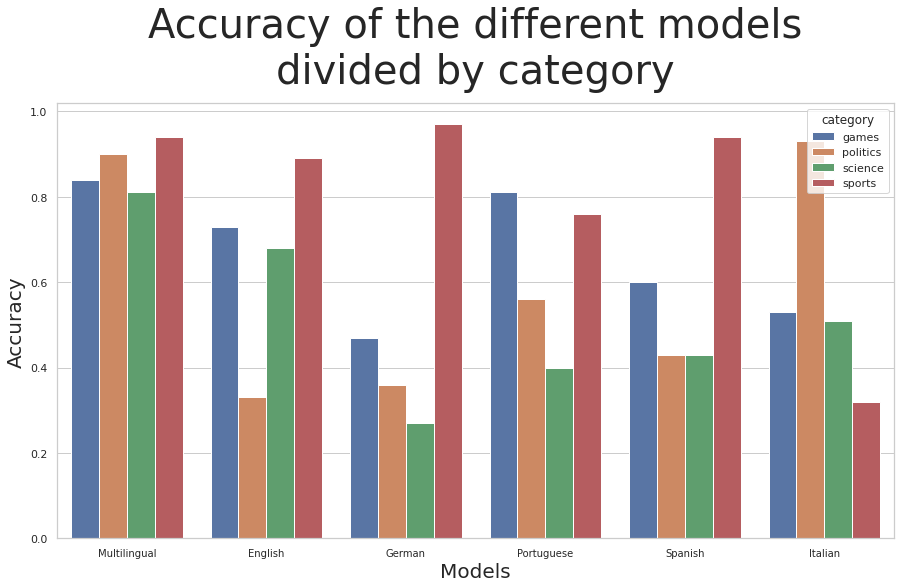

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,8))
plt.xticks(fontsize=10)
g = sns.barplot(x="model", y="accuracy", hue='category', data=df)
g.set_xlabel('Models', fontsize = 20)
g.set_ylabel('Accuracy', fontsize = 20)
g.set_title('Accuracy of the different models\ndivided by category', fontsize = 40, pad=20)

In [ ]:
df = pd.DataFrame()

In [ ]:
df_grouped = df_mu.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Multilingual'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_en.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'English'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_de.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'German'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_pt.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Portuguese'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_es.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Spanish'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df_grouped = df_it.groupby(by=['languageCode']).sum()
df_grouped['accuracy'] = df_grouped.apply(lambda row: "{:.2f}".format(row['correct']/row['total']),axis=1)
df_grouped['category'] = df_grouped.index
df_grouped['model'] = 'Italian'
df_grouped = df_grouped.drop(columns=['correct', 'total'], axis=1)
df = pd.concat([df, df_grouped])

In [ ]:
df['accuracy'] = df['accuracy'].astype(float)

In [ ]:
df['language'] = df.index

Text(0.5, 1.0, 'Accuracy of the different models\ndivided by language')

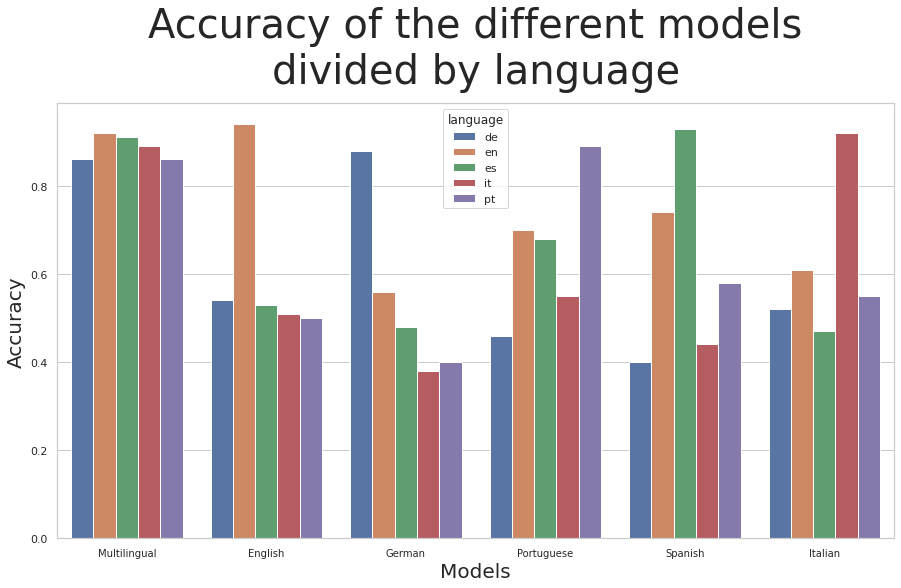

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,8))
plt.xticks(fontsize=10)
g = sns.barplot(x="model", y="accuracy", hue='language', data=df)
g.set_xlabel('Models', fontsize = 20)
g.set_ylabel('Accuracy', fontsize = 20)
g.set_title('Accuracy of the different models\ndivided by language', fontsize = 40, pad=20)

In [ ]:
df_control_plot = [{'model': 'English', 'accuracy': 0.55},
                   {'model': 'German', 'accuracy': 0.38},
                   {'model': 'Portuguese', 'accuracy': 0.40},
                   {'model': 'Spanish', 'accuracy': 0.44},
                   {'model': 'Italian', 'accuracy': 0.39},
                   {'model': 'Multilingual', 'accuracy': 0.62}]

df_control_plot = pd.DataFrame(df_control_plot)

Text(0.5, 1.0, 'Accuracy of the different models\non outside language')

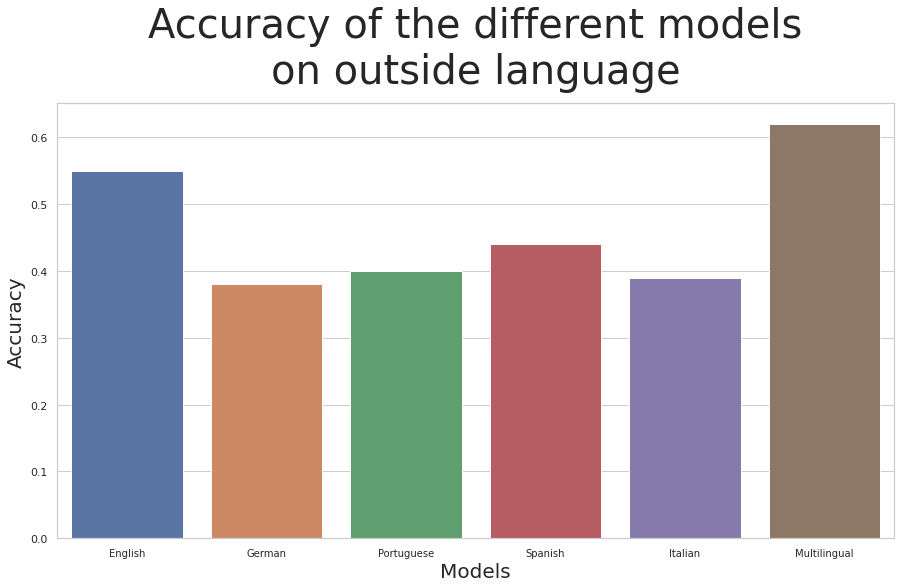

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,8))
plt.xticks(fontsize=10)
g = sns.barplot(x="model", y="accuracy", data=df_control_plot)
g.set_xlabel('Models', fontsize = 20)
g.set_ylabel('Accuracy', fontsize = 20)
g.set_title('Accuracy of the different models\non outside language', fontsize = 40, pad=20)